<a href="https://www.kaggle.com/code/dataranch/heart-attack-feature-importance-28-models?scriptVersionId=106920150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Heart Attack Dataset Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.
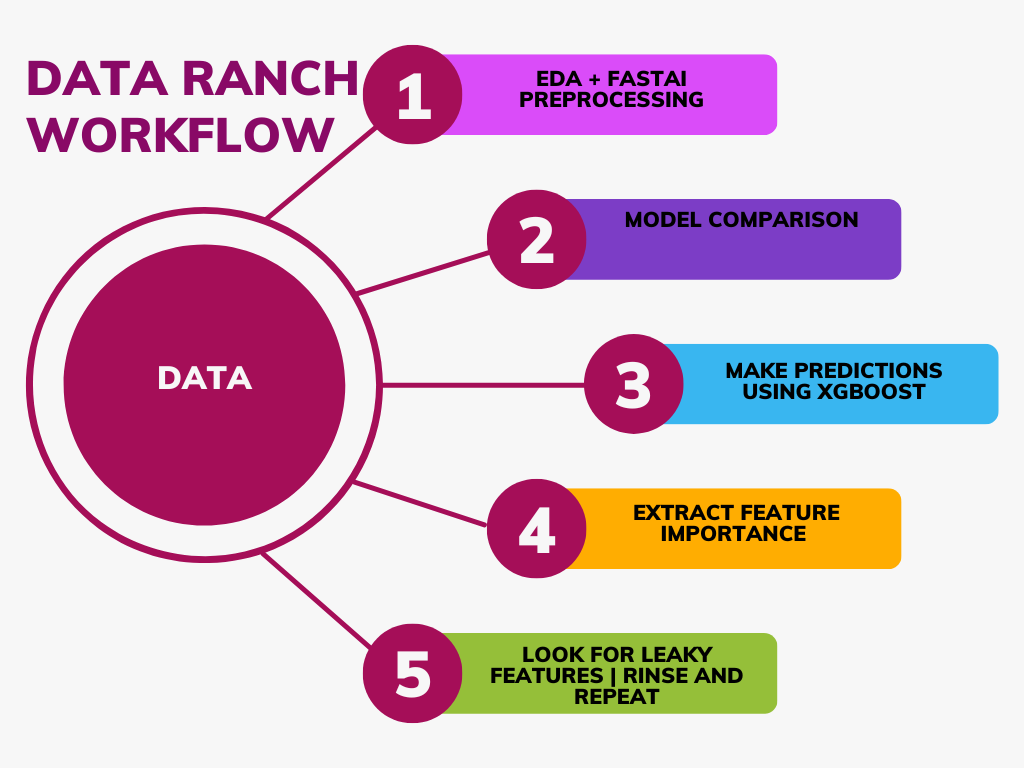

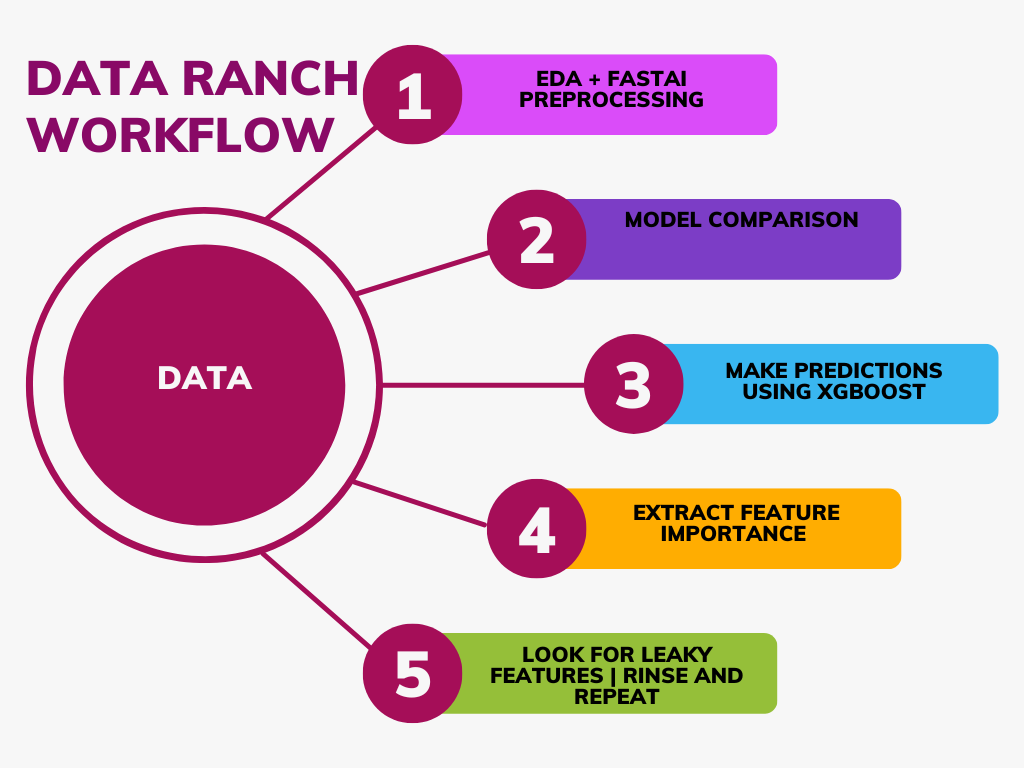

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 495.9 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'heart-attack-analysis-prediction-dataset'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [10]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/heart-attack-analysis-prediction-dataset
CSV!
CSV!


In [11]:
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.20,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.20,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.40,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.20,1,1,3,0


In [12]:
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [13]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

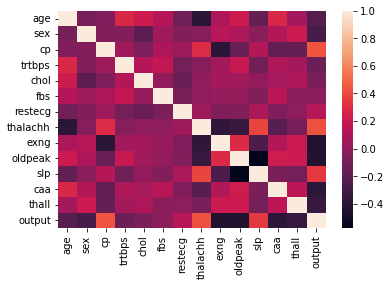

In [14]:
sns.heatmap(df.corr())

In [15]:
df.head().style.background_gradient(cmap = "inferno")

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1


In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
age,303.00,54.37,9.08,29.00,47.50,55.00,61.00,77.00
sex,303.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00
cp,303.00,0.97,1.03,0.00,0.00,1.00,2.00,3.00
trtbps,303.00,131.62,17.54,94.00,120.00,130.00,140.00,200.00
chol,303.00,246.26,51.83,126.00,211.00,240.00,274.50,564.00
fbs,303.00,0.15,0.36,0.00,0.00,0.00,0.00,1.00
restecg,303.00,0.53,0.53,0.00,0.00,1.00,1.00,2.00
thalachh,303.00,149.65,22.91,71.00,133.50,153.00,166.00,202.00
exng,303.00,0.33,0.47,0.00,0.00,0.00,1.00,1.00
oldpeak,303.00,1.04,1.16,0.00,0.00,0.80,1.60,6.20


In [17]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

Target Variable: output
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


  2%|▏         | 1/42 [00:00<00:04,  9.64it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.26615554108227446, 'Adjusted R-Squared': 0.05876471573596076, 'RMSE': 0.4273707196302767, 'Time taken': 0.10359597206115723}
{'Model': 'BaggingRegressor', 'R-Squared': 0.35245535714285725, 'Adjusted R-Squared': 0.1694536102484474, 'RMSE': 0.4014556845614054, 'Time taken': 0.03488922119140625}
{'Model': 'BayesianRidge', 'R-Squared': 0.3674507974495753, 'Adjusted R-Squared': 0.18868689238097713, 'RMSE': 0.396780125750179, 'Time taken': 0.029905080795288086}


 14%|█▍        | 6/42 [00:00<00:01, 30.72it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.0044642857142858094, 'Adjusted R-Squared': -0.2883346273291927, 'RMSE': 0.5, 'Time taken': 0.017119884490966797}
{'Model': 'DummyRegressor', 'R-Squared': -0.03650341018860903, 'Adjusted R-Squared': -0.3294282869810419, 'RMSE': 0.507911588853205, 'Time taken': 0.012705326080322266}
{'Model': 'ElasticNet', 'R-Squared': -0.03650338016450405, 'Adjusted R-Squared': -0.3294282484718638, 'RMSE': 0.5079116, 'Time taken': 0.015923738479614258}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 30.103500366210938 but the user-supplied value was 30.10347557067871.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.5401785714285716, 'Adjusted R-Squared': -0.9754464285714286, 'RMSE': 0.6191391873668903, 'Time taken': 0.011658191680908203}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0

 24%|██▍       | 10/42 [00:00<00:01, 26.00it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.799661418447022, 'Adjusted R-Squared': -6.438696167138572, 'RMSE': 1.2014454987093823, 'Time taken': 0.07484292984008789}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.287498648575662, 'Adjusted R-Squared': 0.08613957099921865, 'RMSE': 0.4211100446294712, 'Time taken': 0.17792773246765137}


 31%|███       | 13/42 [00:00<00:02, 13.20it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2255451165564717, 'Adjusted R-Squared': 0.006677432105039793, 'RMSE': 0.43903669030598536, 'Time taken': 0.17145228385925293}
{'Model': 'HuberRegressor', 'R-Squared': 0.34063458231796895, 'Adjusted R-Squared': 0.1542921816686994, 'RMSE': 0.4051033524653169, 'Time taken': 0.01990199089050293}


 40%|████      | 17/42 [00:00<00:01, 16.29it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4401785714285714, 'Adjusted R-Squared': 0.2819681677018634, 'RMSE': 0.37327380477785116, 'Time taken': 0.014094114303588867}
{'Model': 'KernelRidge', 'R-Squared': -8.925053203478457, 'Adjusted R-Squared': -11.729959543591933, 'RMSE': 1.5716983, 'Time taken': 0.050369977951049805}
{'Model': 'Lars', 'R-Squared': 0.3731633432555229, 'Adjusted R-Squared': 0.19601385330599685, 'RMSE': 0.39498442, 'Time taken': 0.07310152053833008}
{'Model': 'LarsCV', 'R-Squared': 0.346921962429511, 'Adjusted R-Squared': 0.16235643007263378, 'RMSE': 0.40316728, 'Time taken': 0.05950808525085449}
{'Model': 'Lasso', 'R-Squared': -0.03650338016450405, 'Adjusted R-Squared': -0.3294282484718638, 'RMSE': 0.5079116, 'Time taken': 0.01380157470703125}


 50%|█████     | 21/42 [00:01<00:01, 20.63it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 30.103500366210938 but the user-supplied value was 30.10347557067871.
{'Model': 'LassoLars', 'R-Squared': -0.03650338016450405, 'Adjusted R-Squared': -0.3294282484718638, 'RMSE': 0.5079116, 'Time taken': 0.012975215911865234}
{'Model': 'LassoLarsCV', 'R-Squared': 0.346921962429511, 'Adjusted R-Squared': 0.16235643007263378, 'RMSE': 0.40316728, 'Time taken': 0.03186845779418945}
{'Model': 'LassoLarsIC', 'R-Squared': 0.37104667825727633, 'Adjusted R-Squared': 0.19329900037346315, 'RMSE': 0.3956507, 'Time taken': 0.02210521697998047}
{'Model': 'LinearRegression', 'R-Squared': 0.37316362393468283, 'Adjusted R-Squared': 0.196014213307528, 'RMSE': 0.3949843, 'Time taken': 0.012396574020385742}
{'Model': 'LinearSVR', 'R-Squared': 0.2813584966997994, 'Adjusted R-Squared': 0.07826415

 69%|██████▉   | 29/42 [00:02<00:01, 11.78it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.06903885086194339, 'Adjusted R-Squared': -0.19405886519881177, 'RMSE': 0.48135838, 'Time taken': 0.8123681545257568}
{'Model': 'NuSVR', 'R-Squared': 0.3448343209943806, 'Adjusted R-Squared': 0.15967880301453174, 'RMSE': 0.4038111661232798, 'Time taken': 0.06022214889526367}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.09450371412281311, 'Adjusted R-Squared': -0.40381998115752116, 'RMSE': 0.5219289350982459, 'Time taken': 0.027922630310058594}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.2123778960402557, 'Adjusted R-Squared': -0.010210959426628419, 'RMSE': 0.442753193459821, 'Time taken': 0.028610944747924805}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.25694884085469827, 'Adjusted R-Squared': -0.6121735132701565, 'RMSE': 0.5593215536616684, 'Time taken': 0.013713359832763672}
{'Model': 'PoissonRegressor', 'R-Squared': 0.34045308420647535, 'Adjusted R-Squared': 0.15405939061265317, 'RMSE': 0.405159103367978, 'Tim

 76%|███████▌  | 32/42 [00:03<00:02,  4.81it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -1.1428571421422902, 'Adjusted R-Squared': -1.7484472040520678, 'RMSE': 0.7302967432184088, 'Time taken': 1.6123385429382324}
{'Model': 'RANSACRegressor', 'R-Squared': -1.2767887637022461, 'Adjusted R-Squared': -1.9202290664876633, 'RMSE': 0.75277317, 'Time taken': 0.16071510314941406}


 81%|████████  | 34/42 [00:04<00:01,  4.96it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.3676361607142856, 'Adjusted R-Squared': 0.18892464091614902, 'RMSE': 0.39672198493823524, 'Time taken': 0.1904590129852295}
{'Model': 'Ridge', 'R-Squared': 0.3729894750007198, 'Adjusted R-Squared': 0.19579084837048844, 'RMSE': 0.39503917, 'Time taken': 0.014422893524169922}
{'Model': 'RidgeCV', 'R-Squared': 0.37131441579769187, 'Adjusted R-Squared': 0.1936424028709527, 'RMSE': 0.395566500746176, 'Time taken': 0.01277780532836914}
{'Model': 'SGDRegressor', 'R-Squared': 0.3738504758929464, 'Adjusted R-Squared': 0.19689517560182257, 'RMSE': 0.3947678549898802, 'Time taken': 0.012325763702392578}
{'Model': 'SVR', 'R-Squared': 0.3713633490374324, 'Adjusted R-Squared': 0.19370516506975033, 'RMSE': 0.39555110614547107, 'Time taken': 0.017184734344482422}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.37316362393468283, 'Adjusted R-Squared': 0.196014213307528, 'RMSE': 0.3949843, 'Time taken': 0.012702703475952148}
{'Model': 'TweedieRegr

100%|██████████| 42/42 [00:04<00:00,  8.81it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.1975677583842037, 'Adjusted R-Squared': -0.029206570768086415, 'RMSE': 0.44689652, 'Time taken': 0.47913312911987305}
{'Model': 'LGBMRegressor', 'R-Squared': 0.20325757265885336, 'Adjusted R-Squared': -0.021908765502774985, 'RMSE': 0.44530926048261593, 'Time taken': 0.08679747581481934}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: output
output
Target Standard Deviation: 0.49614317420838466
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KNeighborsRegressor                          0.28       0.44  0.37        0.01
ExtraTreesRegressor                          0.21       0.39  0.39        0.14
SGDRegressor                                 0.20       0.37  0.39        0.01
LinearRegression                             0.20       0.37  0.39        0.01
TransformedTargetRegressor           

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,11.688066,3.594319,1.895869,00:00
1,8.172750,3.756966,1.938290,00:00


Better model found at epoch 0 with _rmse value: 1.8958687782287598.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.34
1       1       1.61
2       2       1.92
3       2       1.79
4       2       2.02
XGBoost RMSE:  0.44588575


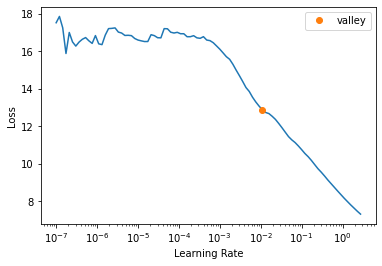

<Figure size 720x720 with 0 Axes>

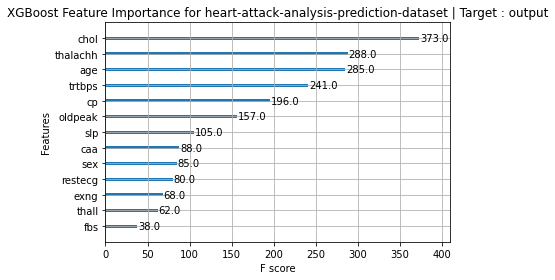

Target Variable: thall
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


 10%|▉         | 4/42 [00:00<00:01, 37.10it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.16396470758373427, 'Adjusted R-Squared': -0.49291125537913727, 'RMSE': 0.6727948735224718, 'Time taken': 0.04686617851257324}
{'Model': 'BaggingRegressor', 'R-Squared': -0.39285714285714346, 'Adjusted R-Squared': -0.7864906832298144, 'RMSE': 0.7359800721939873, 'Time taken': 0.034842729568481445}
{'Model': 'BayesianRidge', 'R-Squared': -0.08578043331194318, 'Adjusted R-Squared': -0.3926314253348835, 'RMSE': 0.6498060836033915, 'Time taken': 0.012906551361083984}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.4571428571428575, 'Adjusted R-Squared': -0.8689440993788824, 'RMSE': 0.752772652709081, 'Time taken': 0.012611150741577148}
{'Model': 'DummyRegressor', 'R-Squared': -0.0014099349185752175, 'Adjusted R-Squared': -0.28441709043904195, 'RMSE': 0.62404903406125, 'Time taken': 0.012394428253173828}
{'Model': 'ElasticNet', 'R-Squared': -0.0014099297778948916, 'Adjusted R-Squared': -0.28441708384556086, 'RMSE': 0.624049, 'Time taken': 0.0

 21%|██▏       | 9/42 [00:00<00:01, 29.18it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.32088714285714315, 'Adjusted R-Squared': -0.694181335403727, 'RMSE': 0.7167135643570124, 'Time taken': 0.1427628993988037}
{'Model': 'GammaRegressor', 'R-Squared': -0.030830729374506705, 'Adjusted R-Squared': -0.3221524572412151, 'RMSE': 0.6331497587293031, 'Time taken': 0.016049623489379883}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -16.225069411603215, 'Adjusted R-Squared': -21.093023810534557, 'RMSE': 2.588172734674477, 'Time taken': 0.04437899589538574}


 31%|███       | 13/42 [00:00<00:01, 16.40it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.20102449733436112, 'Adjusted R-Squared': -0.5404444639723327, 'RMSE': 0.6834215992319059, 'Time taken': 0.15248441696166992}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.3491171227133254, 'Adjusted R-Squared': -0.730389353045352, 'RMSE': 0.7243318706456038, 'Time taken': 0.17507553100585938}


 38%|███▊      | 16/42 [00:00<00:01, 18.35it/s]

{'Model': 'HuberRegressor', 'R-Squared': -0.4142856859032238, 'Adjusted R-Squared': -0.8139751188758739, 'RMSE': 0.7416198412679941, 'Time taken': 0.05717134475708008}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.17428571428571438, 'Adjusted R-Squared': -0.5061490683229815, 'RMSE': 0.6757711644237764, 'Time taken': 0.01435232162475586}
{'Model': 'KernelRidge', 'R-Squared': -28.28389601026263, 'Adjusted R-Squared': -36.55977966533685, 'RMSE': 3.374638, 'Time taken': 0.047518014907836914}
{'Model': 'Lars', 'R-Squared': -0.1645882827959475, 'Adjusted R-Squared': -0.4937110583687152, 'RMSE': 0.67297506, 'Time taken': 0.06969380378723145}
{'Model': 'LarsCV', 'R-Squared': -0.06440293592284974, 'Adjusted R-Squared': -0.36521246129235063, 'RMSE': 0.6433774, 'Time taken': 0.06318354606628418}


 45%|████▌     | 19/42 [00:00<00:01, 18.86it/s]

{'Model': 'Lasso', 'R-Squared': -0.0014099297778948916, 'Adjusted R-Squared': -0.28441708384556086, 'RMSE': 0.624049, 'Time taken': 0.0133056640625}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed -80.0454330444336 but the user-supplied value was -80.04552459716797.
{'Model': 'LassoLars', 'R-Squared': -0.0014099297778948916, 'Adjusted R-Squared': -0.28441708384556086, 'RMSE': 0.624049, 'Time taken': 0.012780427932739258}
{'Model': 'LassoLarsCV', 'R-Squared': -0.06440293592284974, 'Adjusted R-Squared': -0.36521246129235063, 'RMSE': 0.6433774, 'Time taken': 0.030737876892089844}
{'Model': 'LassoLarsIC', 'R-Squared': -0.10607407185515139, 'Adjusted R-Squared': -0.41866022259682456, 'RMSE': 0.6558505, 'Time taken': 0.016293764114379883}
{'Model': 'LinearRegression', 'R-Squared': -0.1645882834643091, 'Adjusted R-Squared': -0.4

 69%|██████▉   | 29/42 [00:01<00:01, 12.50it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.7117762521931454, 'Adjusted R-Squared': -1.195539106073817, 'RMSE': 0.8158987, 'Time taken': 0.8211627006530762}
{'Model': 'NuSVR', 'R-Squared': -0.17606792359836576, 'Adjusted R-Squared': -0.5084349454848602, 'RMSE': 0.6762837777634704, 'Time taken': 0.055197954177856445}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.04052187732626278, 'Adjusted R-Squared': -0.33458240787498905, 'RMSE': 0.6361190114577546, 'Time taken': 0.027611732482910156}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.04052187732626278, 'Adjusted R-Squared': -0.33458240787498905, 'RMSE': 0.6361190114577546, 'Time taken': 0.0321195125579834}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.38758859118374356, 'Adjusted R-Squared': -0.7797331930400189, 'RMSE': 0.7345868127460121, 'Time taken': 0.01324772834777832}
{'Model': 'PoissonRegressor', 'R-Squared': -0.10186467959232215, 'Adjusted R-Squared': -0.4132612194771088, 'RMSE': 0.6546013526968683, 'Ti

 76%|███████▌  | 32/42 [00:03<00:01,  5.69it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.2857142854768169, 'Adjusted R-Squared': -0.6490683226767868, 'RMSE': 0.7071067811212468, 'Time taken': 1.3487977981567383}
{'Model': 'RANSACRegressor', 'R-Squared': -0.4142859595164845, 'Adjusted R-Squared': -0.8139754698146213, 'RMSE': 0.74161994, 'Time taken': 0.15640783309936523}


 95%|█████████▌| 40/42 [00:03<00:00,  9.36it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.1594271428571432, 'Adjusted R-Squared': -0.4870913354037272, 'RMSE': 0.6714821913746734, 'Time taken': 0.2417910099029541}
{'Model': 'Ridge', 'R-Squared': -0.16291188081836494, 'Adjusted R-Squared': -0.4915608906148592, 'RMSE': 0.67249054, 'Time taken': 0.018306255340576172}
{'Model': 'RidgeCV', 'R-Squared': -0.1490334143570089, 'Adjusted R-Squared': -0.473760248849207, 'RMSE': 0.6684656519264871, 'Time taken': 0.013263702392578125}
{'Model': 'SGDRegressor', 'R-Squared': -0.1575059085092585, 'Adjusted R-Squared': -0.4846271435227445, 'RMSE': 0.6709256193070059, 'Time taken': 0.013122320175170898}
{'Model': 'SVR', 'R-Squared': -0.1668117173386361, 'Adjusted R-Squared': -0.49656285484738105, 'RMSE': 0.6736171852754043, 'Time taken': 0.01820230484008789}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.1645882834643091, 'Adjusted R-Squared': -0.4937110592259615, 'RMSE': 0.67297506, 'Time taken': 0.018671751022338867}
{'Model': 'Twe

100%|██████████| 42/42 [00:05<00:00,  7.72it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.39509425728153635, 'Adjusted R-Squared': -0.7893600256437097, 'RMSE': 0.7365709, 'Time taken': 1.5113632678985596}
{'Model': 'LGBMRegressor', 'R-Squared': -0.39403084552952117, 'Adjusted R-Squared': -0.7879960844835161, 'RMSE': 0.7362900967654079, 'Time taken': 0.04507923126220703}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: thall
thall
Target Standard Deviation: 0.6090101654320866
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLars                                   -0.28      -0.00  0.62        0.01
ElasticNet                                  -0.28      -0.00  0.62        0.01
Lasso                                       -0.28      -0.00  0.62        0.01
DummyRegressor                              -0.28      -0.00  0.62        0.01
TweedieRegressor                            

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,30.621819,7.198989,2.683093,00:00
1,19.053123,8.923117,2.987159,00:00


Better model found at epoch 0 with _rmse value: 2.683093309402466.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       4       2.97
1       4       3.75
2       3       2.85
3       3       2.97
4       4       3.62
XGBoost RMSE:  0.7348198


<Figure size 432x288 with 0 Axes>

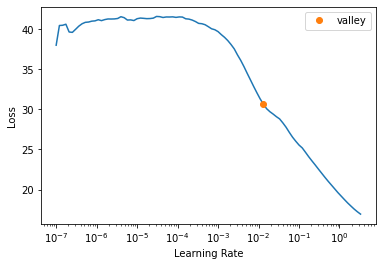

<Figure size 720x720 with 0 Axes>

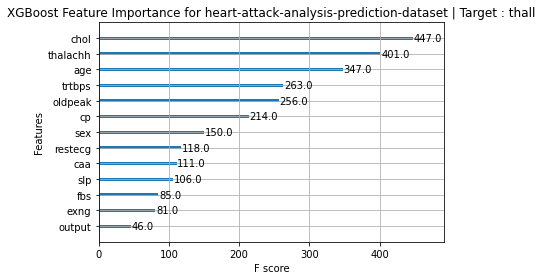

Target Variable: caa
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


 12%|█▏        | 5/42 [00:00<00:00, 45.38it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.2062922519069661, 'Adjusted R-Squared': -0.5472009317937172, 'RMSE': 0.9448048827197894, 'Time taken': 0.03631925582885742}
{'Model': 'BaggingRegressor', 'R-Squared': -0.2927927927927929, 'Adjusted R-Squared': -0.6581472777124953, 'RMSE': 0.9780933834080806, 'Time taken': 0.035988807678222656}
{'Model': 'BayesianRidge', 'R-Squared': 0.11021403383438344, 'Adjusted R-Squared': -0.14124721747329083, 'RMSE': 0.8114441539394784, 'Time taken': 0.013640403747558594}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.567567567567568, 'Adjusted R-Squared': -2.2931844888366633, 'RMSE': 1.378404875209022, 'Time taken': 0.012668132781982422}
{'Model': 'DummyRegressor', 'R-Squared': -0.029573559626151713, 'Adjusted R-Squared': -0.32054000039006403, 'RMSE': 0.8728599166666735, 'Time taken': 0.011203765869140625}
{'Model': 'ElasticNet', 'R-Squared': -0.029573551773488083, 'Adjusted R-Squared': -0.3205399903181694, 'RMSE': 0.87285995, 'Time taken': 0.0147

 24%|██▍       | 10/42 [00:00<00:01, 30.23it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.11822747747747786, 'Adjusted R-Squared': -0.4342482863298085, 'RMSE': 0.9096638573304611, 'Time taken': 0.15050458908081055}
{'Model': 'GammaRegressor', 'R-Squared': 0.15731915359106818, 'Adjusted R-Squared': -0.08082978126362983, 'RMSE': 0.7896732402345982, 'Time taken': 0.015004396438598633}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.671857730162773, 'Adjusted R-Squared': -2.4269479582522524, 'RMSE': 1.406120450146591, 'Time taken': 0.049690961837768555}


 33%|███▎      | 14/42 [00:00<00:01, 16.32it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.23115878949149904, 'Adjusted R-Squared': -0.5790949691304008, 'RMSE': 0.9544933232997018, 'Time taken': 0.16788697242736816}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.3910475990525082, 'Adjusted R-Squared': -0.7841697466108255, 'RMSE': 1.0145813044299878, 'Time taken': 0.1746964454650879}
{'Model': 'HuberRegressor', 'R-Squared': 0.08640514070701732, 'Adjusted R-Squared': -0.17178471083230384, 'RMSE': 0.82222879776666, 'Time taken': 0.019131183624267578}


 40%|████      | 17/42 [00:00<00:01, 17.94it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': -0.1504504504504507, 'Adjusted R-Squared': -0.4755777516647084, 'RMSE': 0.9226772639083145, 'Time taken': 0.01760411262512207}
{'Model': 'KernelRidge', 'R-Squared': -2.7646814463513296, 'Adjusted R-Squared': -3.828613159450618, 'RMSE': 1.6690909, 'Time taken': 0.04033493995666504}
{'Model': 'Lars', 'R-Squared': 0.05040737622412772, 'Adjusted R-Squared': -0.21795575658209687, 'RMSE': 0.83827114, 'Time taken': 0.06914353370666504}
{'Model': 'LarsCV', 'R-Squared': 0.08364913260631313, 'Adjusted R-Squared': -0.17531959078755488, 'RMSE': 0.8234681, 'Time taken': 0.05301380157470703}
{'Model': 'Lasso', 'R-Squared': -0.029573551773488083, 'Adjusted R-Squared': -0.3205399903181694, 'RMSE': 0.87285995, 'Time taken': 0.012404441833496094}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 

 52%|█████▏    | 22/42 [00:00<00:00, 23.36it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.08364913260631313, 'Adjusted R-Squared': -0.17531959078755488, 'RMSE': 0.8234681, 'Time taken': 0.033121347427368164}
{'Model': 'LassoLarsIC', 'R-Squared': 0.09776641244469164, 'Adjusted R-Squared': -0.15721264490789544, 'RMSE': 0.8171003, 'Time taken': 0.018967866897583008}
{'Model': 'LinearRegression', 'R-Squared': 0.05040717468927869, 'Adjusted R-Squared': -0.21795601507244688, 'RMSE': 0.83827126, 'Time taken': 0.011424541473388672}
{'Model': 'LinearSVR', 'R-Squared': -0.0810676664355563, 'Adjusted R-Squared': -0.3865867895586481, 'RMSE': 0.8944216417117329, 'Time taken': 0.012938261032104492}


 69%|██████▉   | 29/42 [00:01<00:01, 11.88it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.12467545403486469, 'Adjusted R-Squared': -0.4425185171316741, 'RMSE': 0.91228276, 'Time taken': 0.8255479335784912}
{'Model': 'NuSVR', 'R-Squared': 0.13187867168819067, 'Adjusted R-Squared': -0.11345996457384233, 'RMSE': 0.8015046992692799, 'Time taken': 0.055438995361328125}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.035986569158898085, 'Adjusted R-Squared': -0.32876538218206486, 'RMSE': 0.8755741323140973, 'Time taken': 0.03003072738647461}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.04281686095644466, 'Adjusted R-Squared': -0.22769141746890798, 'RMSE': 0.8416148304849618, 'Time taken': 0.028865814208984375}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.6222401242868953, 'Adjusted R-Squared': -1.080699289846235, 'RMSE': 1.095654001942357, 'Time taken': 0.015661001205444336}
{'Model': 'PoissonRegressor', 'R-Squared': 0.14078475114513334, 'Adjusted R-Squared': -0.10203694961819854, 'RMSE': 0.7973827714169659, '

 76%|███████▌  | 32/42 [00:03<00:02,  4.87it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.4864864864583889, 'Adjusted R-Squared': -0.9065804935009769, 'RMSE': 1.0488088481602391, 'Time taken': 1.5710501670837402}
{'Model': 'RANSACRegressor', 'R-Squared': 0.009008842545453977, 'Adjusted R-Squared': -0.27105387586561336, 'RMSE': 0.85634893, 'Time taken': 0.1490790843963623}


 81%|████████  | 34/42 [00:03<00:01,  4.99it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.1474909909909914, 'Adjusted R-Squared': -0.47178192322757573, 'RMSE': 0.9214897358806192, 'Time taken': 0.20585346221923828}
{'Model': 'Ridge', 'R-Squared': 0.05243207343373124, 'Adjusted R-Squared': -0.2153588623349969, 'RMSE': 0.837377, 'Time taken': 0.020045757293701172}
{'Model': 'RidgeCV', 'R-Squared': 0.06841074174762551, 'Adjusted R-Squared': -0.1948644834106541, 'RMSE': 0.8302867282491977, 'Time taken': 0.013090372085571289}
{'Model': 'SGDRegressor', 'R-Squared': 0.07412167891473986, 'Adjusted R-Squared': -0.18753958573979013, 'RMSE': 0.8277378556059233, 'Time taken': 0.013049602508544922}
{'Model': 'SVR', 'R-Squared': 0.10445306954219757, 'Adjusted R-Squared': -0.14863628036979004, 'RMSE': 0.8140667838321213, 'Time taken': 0.017662525177001953}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.05040717468927869, 'Adjusted R-Squared': -0.21795601507244688, 'RMSE': 0.83827126, 'Time taken': 0.012919187545776367}
{'Model': '

100%|██████████| 42/42 [00:04<00:00,  9.19it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.38648949782044206, 'Adjusted R-Squared': -0.7783234863349147, 'RMSE': 1.0129178, 'Time taken': 0.4898409843444824}
{'Model': 'LGBMRegressor', 'R-Squared': -0.33141969306013297, 'Adjusted R-Squared': -0.7076904758814748, 'RMSE': 0.9925978908221084, 'Time taken': 0.04537343978881836}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: caa
caa
Target Standard Deviation: 1.0357732906762467
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GammaRegressor                              -0.08       0.16  0.79        0.02
PoissonRegressor                            -0.10       0.14  0.80        0.01
TweedieRegressor                            -0.10       0.14  0.80        0.01
NuSVR                                       -0.11       0.13  0.80        0.06
BayesianRidge                               -0.1

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,5.453466,5.518964,2.349248,00:00
1,5.397277,8.453351,2.907465,00:00


Better model found at epoch 0 with _rmse value: 2.349247694015503.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.12
1       1       2.40
2       1       1.33
3       2       3.48
4       2       3.07
XGBoost RMSE:  1.022261


<Figure size 432x288 with 0 Axes>

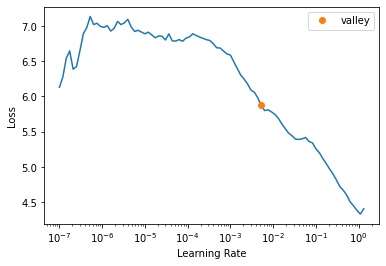

<Figure size 720x720 with 0 Axes>

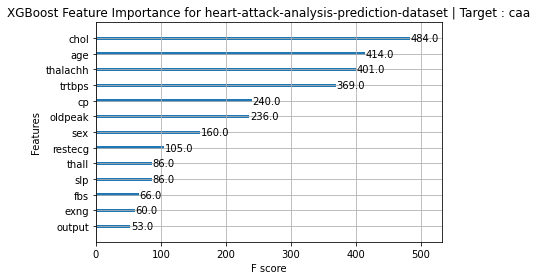

Target Variable: slp
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


 12%|█▏        | 5/42 [00:00<00:00, 45.18it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.31712466727812916, 'Adjusted R-Squared': 0.12413816020455704, 'RMSE': 0.4379202620790594, 'Time taken': 0.036379098892211914}
{'Model': 'BaggingRegressor', 'R-Squared': 0.3655786350148368, 'Adjusted R-Squared': 0.18628564056250807, 'RMSE': 0.42209793492348036, 'Time taken': 0.035727739334106445}
{'Model': 'BayesianRidge', 'R-Squared': 0.38191864998477554, 'Adjusted R-Squared': 0.20724348585003827, 'RMSE': 0.4166267463761084, 'Time taken': 0.013202667236328125}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.6023738872403563, 'Adjusted R-Squared': -1.055218681460457, 'RMSE': 0.6708203932499369, 'Time taken': 0.013368606567382812}
{'Model': 'DummyRegressor', 'R-Squared': -0.015371450888798988, 'Adjusted R-Squared': -0.3023242522269378, 'RMSE': 0.5339945216241496, 'Time taken': 0.011618614196777344}
{'Model': 'ElasticNet', 'R-Squared': -0.015371422916208743, 'Adjusted R-Squared': -0.30232421634905027, 'RMSE': 0.5339945, 'Time taken': 0.0147

 24%|██▍       | 10/42 [00:00<00:01, 29.85it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.23663501483679505, 'Adjusted R-Squared': 0.020901432073280657, 'RMSE': 0.46301007908395836, 'Time taken': 0.15294981002807617}
{'Model': 'GammaRegressor', 'R-Squared': 0.32307486906924154, 'Adjusted R-Squared': 0.13176994076272286, 'RMSE': 0.43600818907032923, 'Time taken': 0.015659809112548828}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -11.651938533857122, 'Adjusted R-Squared': -15.227486380381958, 'RMSE': 1.8849631486030547, 'Time taken': 0.04977011680603027}


 33%|███▎      | 14/42 [00:00<00:01, 16.16it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.11448974247210808, 'Adjusted R-Squared': -0.1357631563944699, 'RMSE': 0.49867905241990695, 'Time taken': 0.17058825492858887}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2567845766221092, 'Adjusted R-Squared': 0.04674543523270536, 'RMSE': 0.45685847341595587, 'Time taken': 0.17487597465515137}
{'Model': 'HuberRegressor', 'R-Squared': 0.3877791050573278, 'Adjusted R-Squared': 0.21476015648657265, 'RMSE': 0.41464687948068185, 'Time taken': 0.01961994171142578}


 43%|████▎     | 18/42 [00:00<00:01, 17.94it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.1715133531157269, 'Adjusted R-Squared': -0.06262417752548055, 'RMSE': 0.48235533237092615, 'Time taken': 0.016866683959960938}
{'Model': 'KernelRidge', 'R-Squared': -20.393524305756795, 'Adjusted R-Squared': -26.4395203052098, 'RMSE': 2.4511254, 'Time taken': 0.03513455390930176}
{'Model': 'Lars', 'R-Squared': 0.36998099163001785, 'Adjusted R-Squared': 0.19193214143850124, 'RMSE': 0.42063087, 'Time taken': 0.03752493858337402}
{'Model': 'LarsCV', 'R-Squared': 0.3856036061426563, 'Adjusted R-Squared': 0.2119698426612332, 'RMSE': 0.41538295, 'Time taken': 0.0887308120727539}
{'Model': 'Lasso', 'R-Squared': -0.015371422916208743, 'Adjusted R-Squared': -0.30232421634905027, 'RMSE': 0.5339945, 'Time taken': 0.014238357543945312}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed -63

 60%|█████▉    | 25/42 [00:01<00:00, 27.11it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.3856036061426563, 'Adjusted R-Squared': 0.2119698426612332, 'RMSE': 0.41538295, 'Time taken': 0.03215527534484863}
{'Model': 'LassoLarsIC', 'R-Squared': 0.39027258702011447, 'Adjusted R-Squared': 0.21795831813449473, 'RMSE': 0.4138016, 'Time taken': 0.016379117965698242}
{'Model': 'LinearRegression', 'R-Squared': 0.36998056265608714, 'Adjusted R-Squared': 0.19193159123280745, 'RMSE': 0.42063102, 'Time taken': 0.01174473762512207}
{'Model': 'LinearSVR', 'R-Squared': 0.3309724050134206, 'Adjusted R-Squared': 0.1418993890389526, 'RMSE': 0.4334573215347324, 'Time taken': 0.015259265899658203}


 69%|██████▉   | 29/42 [00:01<00:01, 10.76it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.18516352511900924, 'Adjusted R-Squared': -0.045116348216922786, 'RMSE': 0.47836518, 'Time taken': 0.8284544944763184}
{'Model': 'NuSVR', 'R-Squared': 0.2431200078144652, 'Adjusted R-Squared': 0.0292191404576837, 'RMSE': 0.4610391861206279, 'Time taken': 0.055477142333984375}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.317401769524449, 'Adjusted R-Squared': 0.12449357395527161, 'RMSE': 0.4378314017882727, 'Time taken': 0.028535127639770508}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.393545492109184, 'Adjusted R-Squared': 0.2221561746617795, 'RMSE': 0.4126895212699302, 'Time taken': 0.03268027305603027}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5995636899216563, 'Adjusted R-Squared': -1.0516142979429937, 'RMSE': 0.6702319023440059, 'Time taken': 0.014593362808227539}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3728196798316812, 'Adjusted R-Squared': 0.19557306761019988, 'RMSE': 0.4196821891788311, 'Time taken'

 76%|███████▌  | 32/42 [00:03<00:02,  4.71it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.7210682492090363, 'Adjusted R-Squared': -1.2074571022463725, 'RMSE': 0.6952217871438853, 'Time taken': 1.7982814311981201}
{'Model': 'RANSACRegressor', 'R-Squared': 0.2971995502460929, 'Adjusted R-Squared': 0.09858203183738012, 'RMSE': 0.44426322, 'Time taken': 0.16160178184509277}


 81%|████████  | 34/42 [00:04<00:01,  4.83it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.33821364985163194, 'Adjusted R-Squared': 0.1511870726357888, 'RMSE': 0.4311051689166655, 'Time taken': 0.20019268989562988}
{'Model': 'Ridge', 'R-Squared': 0.3708240126203014, 'Adjusted R-Squared': 0.19301340749125617, 'RMSE': 0.4203494, 'Time taken': 0.01342320442199707}
{'Model': 'RidgeCV', 'R-Squared': 0.3767374964739356, 'Adjusted R-Squared': 0.20059809330352618, 'RMSE': 0.4183693181949449, 'Time taken': 0.012433290481567383}
{'Model': 'SGDRegressor', 'R-Squared': 0.37713296065146995, 'Adjusted R-Squared': 0.20110531909645069, 'RMSE': 0.41823656808523113, 'Time taken': 0.012137651443481445}
{'Model': 'SVR', 'R-Squared': 0.21814347528559974, 'Adjusted R-Squared': -0.0028159773510785246, 'RMSE': 0.46858443638682745, 'Time taken': 0.017577648162841797}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.36998056265608714, 'Adjusted R-Squared': 0.19193159123280745, 'RMSE': 0.42063102, 'Time taken': 0.012971878051757812}
{'Model': 'Tw

100%|██████████| 42/42 [00:04<00:00,  8.78it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.17397015218156442, 'Adjusted R-Squared': -0.059473065680167414, 'RMSE': 0.4816396, 'Time taken': 0.4776017665863037}
{'Model': 'LGBMRegressor', 'R-Squared': 0.2695499831379401, 'Adjusted R-Squared': 0.06311845663344495, 'RMSE': 0.4529179981726955, 'Time taken': 0.04603433609008789}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: slp
slp
Target Standard Deviation: 0.6339575636217236
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuitCV                  0.22       0.39  0.41        0.03
LassoLarsIC                                  0.22       0.39  0.41        0.02
HuberRegressor                               0.21       0.39  0.41        0.02
LarsCV                                       0.21       0.39  0.42        0.09
LassoLarsCV                                  0.21

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,4.378417,4.285972,2.070259,00:00
1,4.206166,4.072355,2.018008,00:00
2,3.832798,6.586437,2.566405,00:00


Better model found at epoch 0 with _rmse value: 2.070258855819702.
Better model found at epoch 1 with _rmse value: 2.018007755279541.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.11
1       2       2.46
2       2       2.22
3       3       2.62
4       2       2.09
XGBoost RMSE:  0.4834088


<Figure size 432x288 with 0 Axes>

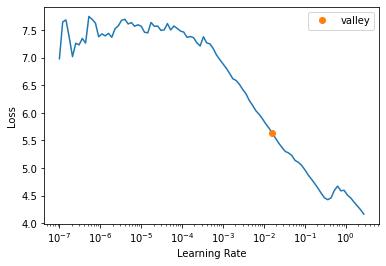

<Figure size 720x720 with 0 Axes>

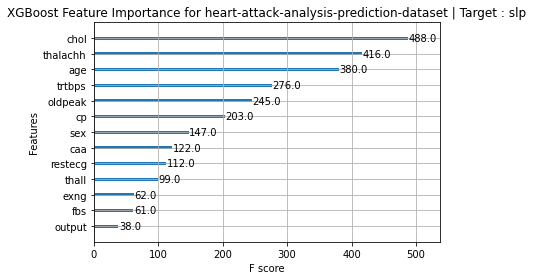

Target Variable: oldpeak
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


  2%|▏         | 1/42 [00:00<00:04,  9.80it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.2271297057885736, 'Adjusted R-Squared': 0.008709840033170546, 'RMSE': 0.9638535506449908, 'Time taken': 0.10154438018798828}
{'Model': 'BaggingRegressor', 'R-Squared': 0.1959092169957395, 'Adjusted R-Squared': -0.03133383037502968, 'RMSE': 0.9831284996791633, 'Time taken': 0.03851151466369629}
{'Model': 'BayesianRidge', 'R-Squared': 0.32965915483184005, 'Adjusted R-Squared': 0.14021500293649058, 'RMSE': 0.8976470030433544, 'Time taken': 0.013165950775146484}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.899286139373191, 'Adjusted R-Squared': -1.4360409178917015, 'RMSE': 1.5109599167342065, 'Time taken': 0.013162374496459961}
{'Model': 'DummyRegressor', 'R-Squared': -0.006100662078718955, 'Adjusted R-Squared': -0.29043345788357433, 'RMSE': 1.0997107, 'Time taken': 0.011809587478637695}


 17%|█▋        | 7/42 [00:00<00:00, 35.64it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.1044351757096198, 'Adjusted R-Squared': -0.14865923115505275, 'RMSE': 1.0375433, 'Time taken': 0.01374673843383789}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 36.36735153198242 but the user-supplied value was 36.36738204956055.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.29516953607443375, 'Adjusted R-Squared': -0.6611957093128606, 'RMSE': 1.2477312557392541, 'Time taken': 0.015002012252807617}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.034651174735633616, 'Adjusted R-Squared': -0.23816479762168719, 'RMSE': 1.077208769105197, 'Time taken': 0.16110467910766602}


 26%|██▌       | 11/42 [00:00<00:01, 24.56it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.5017377741727791, 'Adjusted R-Squared': -0.9261419277433469, 'RMSE': 1.3435529797205512, 'Time taken': 0.03499650955200195}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.15020620369519233, 'Adjusted R-Squared': -0.08995291265181837, 'RMSE': 1.010681979093361, 'Time taken': 0.14416193962097168}


 43%|████▎     | 18/42 [00:00<00:01, 18.02it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.08610942211755956, 'Adjusted R-Squared': -0.39305338923773925, 'RMSE': 1.1426008283710711, 'Time taken': 0.18625831604003906}
{'Model': 'HuberRegressor', 'R-Squared': 0.3343968514855489, 'Adjusted R-Squared': 0.1462916138618997, 'RMSE': 0.8944692762692654, 'Time taken': 0.017550230026245117}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.06732263882975409, 'Adjusted R-Squared': -0.19626009367488062, 'RMSE': 1.0588232, 'Time taken': 0.015069961547851562}
{'Model': 'KernelRidge', 'R-Squared': -0.5776936669823385, 'Adjusted R-Squared': -1.0235636163469124, 'RMSE': 1.3771116, 'Time taken': 0.021498441696166992}
{'Model': 'Lars', 'R-Squared': 0.3123115836707625, 'Adjusted R-Squared': 0.11796485731684758, 'RMSE': 0.90918773, 'Time taken': 0.03597831726074219}
{'Model': 'LarsCV', 'R-Squared': 0.3394669347562719, 'Adjusted R-Squared': 0.15279454675260962, 'RMSE': 0.89105606, 'Time taken': 0.08151650428771973}
{'Model': 'Lasso', 'R-Squ

 55%|█████▍    | 23/42 [00:01<00:00, 24.35it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 36.36735153198242 but the user-supplied value was 36.36738204956055.
{'Model': 'LassoLars', 'R-Squared': -0.006100662078718955, 'Adjusted R-Squared': -0.29043345788357433, 'RMSE': 1.0997107, 'Time taken': 0.012754201889038086}
{'Model': 'LassoLarsCV', 'R-Squared': 0.3394669347562719, 'Adjusted R-Squared': 0.15279454675260962, 'RMSE': 0.89105606, 'Time taken': 0.03059530258178711}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3394761550440508, 'Adjusted R-Squared': 0.1528063727738913, 'RMSE': 0.89104986, 'Time taken': 0.015987634658813477}
{'Model': 'LinearRegression', 'R-Squared': 0.312311957071179, 'Adjusted R-Squared': 0.11796533624346872, 'RMSE': 0.9091875, 'Time taken': 0.012175798416137695}
{'Model': 'LinearSVR', 'R-Squared': 0.3336583058329946, 'Adjusted R-Squared': 0.145344

 64%|██████▍   | 27/42 [00:01<00:01,  9.87it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0932970598011359, 'Adjusted R-Squared': -0.16294507547245596, 'RMSE': 1.0439754, 'Time taken': 0.8423912525177002}
{'Model': 'NuSVR', 'R-Squared': 0.2321077826836231, 'Adjusted R-Squared': 0.015094764746386158, 'RMSE': 0.960744433668982, 'Time taken': 0.05118060111999512}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.30288971663900166, 'Adjusted R-Squared': 0.10588028873263267, 'RMSE': 0.9153949001822729, 'Time taken': 0.029856204986572266}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3215629406669903, 'Adjusted R-Squared': 0.12983072824679198, 'RMSE': 0.9030515148333877, 'Time taken': 0.033709049224853516}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.3259495308001541, 'Adjusted R-Squared': -0.7006743982001975, 'RMSE': 1.2624705062039459, 'Time taken': 0.01298975944519043}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3871504141635872, 'Adjusted R-Squared': 0.2139537920793836, 'RMSE': 0.8582912645513979, 'Time taken'

 76%|███████▌  | 32/42 [00:04<00:02,  4.00it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.21780045294958517, 'Adjusted R-Squared': -0.5619614505222938, 'RMSE': 1.209889783734441, 'Time taken': 2.465773105621338}
{'Model': 'RANSACRegressor', 'R-Squared': -1.1953577582075843, 'Adjusted R-Squared': -1.81578495074451, 'RMSE': 1.624465, 'Time taken': 0.15926241874694824}


 81%|████████  | 34/42 [00:04<00:01,  4.17it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.31182704508095027, 'Adjusted R-Squared': 0.11734338390817545, 'RMSE': 0.9095080438860946, 'Time taken': 0.21492767333984375}
{'Model': 'Ridge', 'R-Squared': 0.31321178099070424, 'Adjusted R-Squared': 0.11911945822720771, 'RMSE': 0.9085925, 'Time taken': 0.012665033340454102}
{'Model': 'RidgeCV', 'R-Squared': 0.3202976095714585, 'Adjusted R-Squared': 0.12820780358078376, 'RMSE': 0.9038932486824898, 'Time taken': 0.012816429138183594}
{'Model': 'SGDRegressor', 'R-Squared': 0.31105027125633333, 'Adjusted R-Squared': 0.1163470870461667, 'RMSE': 0.9100212017987334, 'Time taken': 0.012982368469238281}
{'Model': 'SVR', 'R-Squared': 0.18607106424651643, 'Adjusted R-Squared': -0.043952330640337545, 'RMSE': 0.9891245657454604, 'Time taken': 0.018019676208496094}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.312311957071179, 'Adjusted R-Squared': 0.11796533624346872, 'RMSE': 0.9091875, 'Time taken': 0.013237237930297852}
{'Model': 'Tweedi

100%|██████████| 42/42 [00:05<00:00,  7.59it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.08185809732369764, 'Adjusted R-Squared': -0.17761678821525728, 'RMSE': 1.0505401, 'Time taken': 0.48882460594177246}
{'Model': 'LGBMRegressor', 'R-Squared': -0.05859805176749888, 'Adjusted R-Squared': -0.35776706639744416, 'RMSE': 1.1280368552066373, 'Time taken': 0.04604291915893555}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: oldpeak
oldpeak
Target Standard Deviation: 1.1740409135818481
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
PoissonRegressor                             0.21       0.39  0.86        0.01
LassoLarsIC                                  0.15       0.34  0.89        0.02
LassoLarsCV                                  0.15       0.34  0.89        0.03
LarsCV                                       0.15       0.34  0.89        0.08
HuberRegressor                        

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,7.431499,3.680283,1.918406,00:00
1,6.078762,2.061223,1.435696,00:00
2,6.272296,6.551139,2.559519,00:00


Better model found at epoch 0 with _rmse value: 1.918406367301941.
Better model found at epoch 1 with _rmse value: 1.435696005821228.
No improvement since epoch 1: early stopping


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age,trtbps,chol,thalachh,oldpeak,oldpeak_pred
0,2.00,1.00,1.00,1.00,2.00,2.00,2.00,3.00,1.00,-0.02,-1.29,-0.79,-1.82,0.00,5.19
1,2.00,1.00,1.00,2.00,2.00,3.00,2.00,4.00,1.00,0.53,0.51,-1.34,0.52,0.00,0.93
2,1.00,1.00,2.00,1.00,2.00,1.00,3.00,4.00,1.00,0.20,4.12,0.74,-0.74,4.00,4.12
3,1.00,3.00,1.00,1.00,2.00,3.00,1.00,3.00,2.00,-1.45,-1.17,0.37,0.95,0.00,2.27
4,2.00,2.00,1.00,2.00,1.00,3.00,1.00,3.00,2.00,0.09,-0.09,0.26,0.22,0.00,1.30
5,2.00,3.00,2.00,2.00,1.00,1.00,1.00,4.00,2.00,-1.34,-0.69,-0.16,1.90,0.80,1.01
6,2.00,4.00,1.00,1.00,1.00,3.00,3.00,3.00,2.00,-1.34,1.00,-0.08,1.21,0.80,1.18
7,1.00,3.00,1.00,3.00,1.00,2.00,1.00,3.00,2.00,2.40,0.51,-0.96,-1.47,1.10,1.04
8,2.00,3.00,1.00,1.00,1.00,3.00,1.00,4.00,2.00,-0.02,1.12,-0.30,0.65,1.60,1.04


<Figure size 432x288 with 0 Axes>

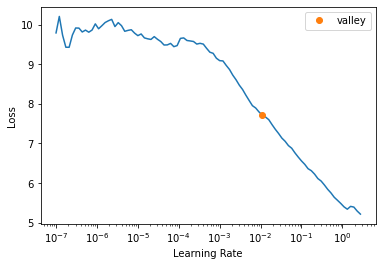

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    1.60       0.71
1    0.00       0.30
2    1.50       1.67
3    1.80       1.49
4    0.00       0.22
XGBoost RMSE:  1.043948


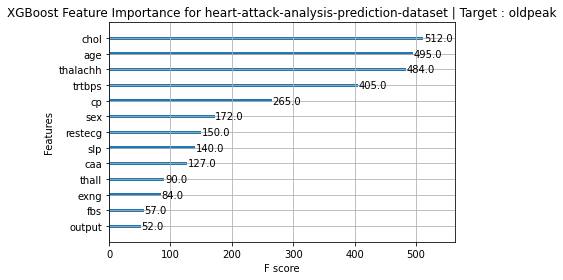

Target Variable: exng
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


  2%|▏         | 1/42 [00:00<00:04,  9.71it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.10781723562852641, 'Adjusted R-Squared': -0.1443213716938465, 'RMSE': 0.4627351979795287, 'Time taken': 0.10257530212402344}
{'Model': 'BaggingRegressor', 'R-Squared': 0.09305555555555545, 'Adjusted R-Squared': -0.16325483091787452, 'RMSE': 0.4665476038590989, 'Time taken': 0.03454995155334473}
{'Model': 'BayesianRidge', 'R-Squared': 0.28074090798642115, 'Adjusted R-Squared': 0.07747203415649673, 'RMSE': 0.4154782570523503, 'Time taken': 0.012324094772338867}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.31944444444444464, 'Adjusted R-Squared': -0.6923309178743964, 'RMSE': 0.5627314338711378, 'Time taken': 0.01286458969116211}
{'Model': 'DummyRegressor', 'R-Squared': -0.03381201192996852, 'Adjusted R-Squared': -0.3259762761710465, 'RMSE': 0.49811131573493933, 'Time taken': 0.01132059097290039}


 17%|█▋        | 7/42 [00:00<00:00, 38.82it/s]

{'Model': 'ElasticNet', 'R-Squared': -0.03381201003988599, 'Adjusted R-Squared': -0.32597627374681015, 'RMSE': 0.4981113, 'Time taken': 0.015601634979248047}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed -79.7461929321289 but the user-supplied value was -79.7462387084961.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.5277777777777779, 'Adjusted R-Squared': -0.9595410628019323, 'RMSE': 0.6055300708194983, 'Time taken': 0.013425350189208984}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.15425694444444438, 'Adjusted R-Squared': -0.08475739734299514, 'RMSE': 0.45053116799321813, 'Time taken': 0.14015865325927734}
{'Model': 'GammaRegressor', 'R-Squared': 0.24287431196787135, 'Adjusted R-Squared': 0.028904008828356753, 'RMSE': 0.4262747530967684, 'Time taken': 0.014379024505615234}


 26%|██▌       | 11/42 [00:00<00:01, 25.48it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.988337346099351, 'Adjusted R-Squared': -6.680693552605689, 'RMSE': 1.198833167318891, 'Time taken': 0.05022263526916504}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.08034359420028858, 'Adjusted R-Squared': -0.17955930309093415, 'RMSE': 0.4698058507425495, 'Time taken': 0.16601324081420898}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.056026260409203, 'Adjusted R-Squared': -0.21074892686645685, 'RMSE': 0.47597657242955904, 'Time taken': 0.1902327537536621}


 40%|████      | 17/42 [00:00<00:01, 16.61it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.23113341502698692, 'Adjusted R-Squared': 0.01384503231722245, 'RMSE': 0.42956720125438247, 'Time taken': 0.019355297088623047}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.1777777777777777, 'Adjusted R-Squared': -0.05458937198067626, 'RMSE': 0.44422216663887154, 'Time taken': 0.013708829879760742}
{'Model': 'KernelRidge', 'R-Squared': -7.716500132448145, 'Adjusted R-Squared': -10.179858865531315, 'RMSE': 1.4463611, 'Time taken': 0.03836846351623535}
{'Model': 'Lars', 'R-Squared': 0.2721454097985163, 'Adjusted R-Squared': 0.06644737343722751, 'RMSE': 0.41795346, 'Time taken': 0.07748699188232422}
{'Model': 'LarsCV', 'R-Squared': 0.2501086333585488, 'Adjusted R-Squared': 0.03818281235118226, 'RMSE': 0.42423332, 'Time taken': 0.05711936950683594}


 52%|█████▏    | 22/42 [00:01<00:00, 22.18it/s]

{'Model': 'Lasso', 'R-Squared': -0.03381201003988599, 'Adjusted R-Squared': -0.32597627374681015, 'RMSE': 0.4981113, 'Time taken': 0.01397395133972168}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed -79.7461929321289 but the user-supplied value was -79.7462387084961.
{'Model': 'LassoLars', 'R-Squared': -0.03381201003988599, 'Adjusted R-Squared': -0.32597627374681015, 'RMSE': 0.4981113, 'Time taken': 0.011945962905883789}
{'Model': 'LassoLarsCV', 'R-Squared': 0.2501086333585488, 'Adjusted R-Squared': 0.03818281235118226, 'RMSE': 0.42423332, 'Time taken': 0.029667377471923828}
{'Model': 'LassoLarsIC', 'R-Squared': 0.25523365324908, 'Adjusted R-Squared': 0.04475620742816788, 'RMSE': 0.42278117, 'Time taken': 0.017426490783691406}
{'Model': 'LinearRegression', 'R-Squared': 0.27214557434859254, 'Adjusted R-Squared': 0.0664475

 69%|██████▉   | 29/42 [00:02<00:01, 10.65it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.1140166034928396, 'Adjusted R-Squared': -0.4288473827408159, 'RMSE': 0.5170725, 'Time taken': 0.9552133083343506}
{'Model': 'NuSVR', 'R-Squared': 0.1094768402778521, 'Adjusted R-Squared': -0.14219274833927664, 'RMSE': 0.4623046163876319, 'Time taken': 0.060976266860961914}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.18497097263144324, 'Adjusted R-Squared': -0.04536331771184443, 'RMSE': 0.4422747636576765, 'Time taken': 0.02789306640625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.23702164248977087, 'Adjusted R-Squared': 0.021397324062967016, 'RMSE': 0.42791915802223085, 'Time taken': 0.02844071388244629}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.47684742466660746, 'Adjusted R-Squared': -0.8942173490289094, 'RMSE': 0.595351477633159, 'Time taken': 0.01521754264831543}
{'Model': 'PoissonRegressor', 'R-Squared': 0.26477166044993616, 'Adjusted R-Squared': 0.056989738403179, 'RMSE': 0.4200652348052803, 'Time taken

 76%|███████▌  | 32/42 [00:03<00:01,  5.36it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.6666666666524479, 'Adjusted R-Squared': -1.1376811594020526, 'RMSE': 0.6324555320309779, 'Time taken': 1.2723793983459473}
{'Model': 'RANSACRegressor', 'R-Squared': -0.18055537343083938, 'Adjusted R-Squared': -0.514190587661294, 'RMSE': 0.5322906, 'Time taken': 0.17317533493041992}


 81%|████████  | 34/42 [00:03<00:01,  5.35it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.1240486111111111, 'Adjusted R-Squared': -0.12350286835748792, 'RMSE': 0.45850663390329843, 'Time taken': 0.19608592987060547}
{'Model': 'Ridge', 'R-Squared': 0.2725732548832537, 'Adjusted R-Squared': 0.06699613126330373, 'RMSE': 0.4178306, 'Time taken': 0.012439489364624023}
{'Model': 'RidgeCV', 'R-Squared': 0.2757633137298916, 'Adjusted R-Squared': 0.07108772847964362, 'RMSE': 0.41691342591097497, 'Time taken': 0.012554645538330078}
{'Model': 'SGDRegressor', 'R-Squared': 0.2673139703287859, 'Adjusted R-Squared': 0.06025052716083412, 'RMSE': 0.4193383444440675, 'Time taken': 0.011653900146484375}
{'Model': 'SVR', 'R-Squared': 0.10373768643110903, 'Adjusted R-Squared': -0.14955383696879476, 'RMSE': 0.4637919309954991, 'Time taken': 0.017634153366088867}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.27214557434859254, 'Adjusted R-Squared': 0.06644758449058619, 'RMSE': 0.41795343, 'Time taken': 0.012606382369995117}
{'Model': 'Twe

100%|██████████| 42/42 [00:04<00:00,  9.37it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.18863694368542783, 'Adjusted R-Squared': -0.5245560799443529, 'RMSE': 0.5341094, 'Time taken': 0.4767136573791504}
{'Model': 'LGBMRegressor', 'R-Squared': 0.04012873235840719, 'Adjusted R-Squared': -0.23113923458378194, 'RMSE': 0.4799678158314183, 'Time taken': 0.058182716369628906}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: exng
exng
Target Standard Deviation: 0.46245928276031795
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BayesianRidge                                0.08       0.28  0.42        0.01
RidgeCV                                      0.07       0.28  0.42        0.01
Ridge                                        0.07       0.27  0.42        0.01
TransformedTargetRegressor                   0.07       0.27  0.42        0.01
LinearRegression                            

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2.906247,8.158068,2.856233,00:00
1,2.528876,2.571896,1.603713,00:00
2,2.388597,4.196139,2.048448,00:00


Better model found at epoch 0 with _rmse value: 2.8562331199645996.
Better model found at epoch 1 with _rmse value: 1.6037132740020752.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.21
1       2       0.99
2       2       1.96
3       1       1.06
4       2       0.72
XGBoost RMSE:  0.5331022


<Figure size 432x288 with 0 Axes>

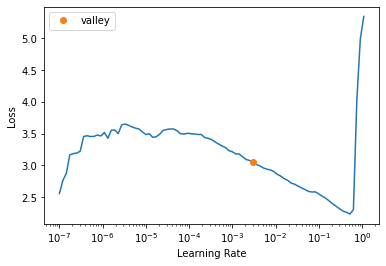

<Figure size 720x720 with 0 Axes>

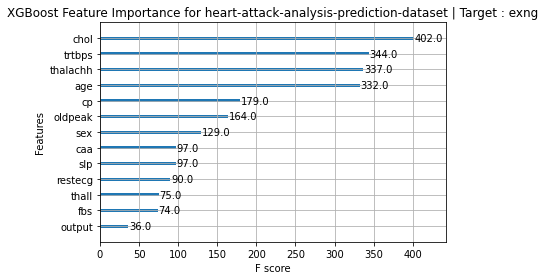

Target Variable: thalachh
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'oldpeak']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


  2%|▏         | 1/42 [00:00<00:04,  9.73it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.2639657569220899, 'Adjusted R-Squared': 0.05595607953050663, 'RMSE': 17.78993081292323, 'Time taken': 0.10260677337646484}
{'Model': 'BaggingRegressor', 'R-Squared': 0.24206401024822333, 'Adjusted R-Squared': 0.027864708796634274, 'RMSE': 18.052672932283464, 'Time taken': 0.0383610725402832}
{'Model': 'BayesianRidge', 'R-Squared': 0.16568420288076646, 'Adjusted R-Squared': -0.07010069630510385, 'RMSE': 18.9404582623095, 'Time taken': 0.013782978057861328}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.32606258101426255, 'Adjusted R-Squared': -0.7008193973878585, 'RMSE': 23.87851195810437, 'Time taken': 0.012576818466186523}


 17%|█▋        | 7/42 [00:00<00:00, 38.23it/s]

{'Model': 'DummyRegressor', 'R-Squared': -0.03487051690769549, 'Adjusted R-Squared': -0.32733392385987026, 'RMSE': 21.094452, 'Time taken': 0.013289451599121094}
{'Model': 'ElasticNet', 'R-Squared': 0.22013413831962525, 'Adjusted R-Squared': -0.00026273563352408047, 'RMSE': 18.311975, 'Time taken': 0.013446569442749023}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 50.70694351196289 but the user-supplied value was 50.70701599121094.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.291102482785976, 'Adjusted R-Squared': -1.938587967051578, 'RMSE': 31.386833757697403, 'Time taken': 0.014657258987426758}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.2361182915407305, 'Adjusted R-Squared': 0.020238678280502187, 'RMSE': 18.123342774812084, 'Time taken': 0.16390442848205566}


 26%|██▌       | 11/42 [00:00<00:01, 24.51it/s]

{'Model': 'GammaRegressor', 'R-Squared': 0.22776395108463077, 'Adjusted R-Squared': 0.009523328565069988, 'RMSE': 18.222178003600156, 'Time taken': 0.0158689022064209}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -31.6597242731064, 'Adjusted R-Squared': -40.889646350288636, 'RMSE': 118.50358969016669, 'Time taken': 0.03592658042907715}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.13198649314341449, 'Adjusted R-Squared': -0.11332167183779429, 'RMSE': 19.31917118436203, 'Time taken': 0.16127705574035645}


 33%|███▎      | 14/42 [00:00<00:01, 14.88it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.18734561031572972, 'Adjusted R-Squared': -0.04231758676895536, 'RMSE': 18.692964963176436, 'Time taken': 0.17369723320007324}
{'Model': 'HuberRegressor', 'R-Squared': 0.113198800394679, 'Adjusted R-Squared': -0.13741892992856375, 'RMSE': 19.5271285421096, 'Time taken': 0.02363276481628418}


 40%|████      | 17/42 [00:00<00:01, 17.74it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.0738484893987682, 'Adjusted R-Squared': -0.18788998098853638, 'RMSE': 19.955667, 'Time taken': 0.020938873291015625}
{'Model': 'KernelRidge', 'R-Squared': -52.47313378216246, 'Adjusted R-Squared': -67.5851063727736, 'RMSE': 151.63277, 'Time taken': 0.04018139839172363}
{'Model': 'Lars', 'R-Squared': 0.12630345272819876, 'Adjusted R-Squared': -0.12061078889209287, 'RMSE': 19.38231, 'Time taken': 0.037313222885131836}


 48%|████▊     | 20/42 [00:01<00:01, 19.23it/s]

{'Model': 'LarsCV', 'R-Squared': 0.1669230886354076, 'Adjusted R-Squared': -0.06851169066328144, 'RMSE': 18.926392, 'Time taken': 0.09860920906066895}
{'Model': 'Lasso', 'R-Squared': 0.1764903659545688, 'Adjusted R-Squared': -0.05624061758000942, 'RMSE': 18.8174, 'Time taken': 0.012220621109008789}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 50.70694351196289 but the user-supplied value was 50.70701599121094.
{'Model': 'LassoLars', 'R-Squared': -0.03487051690769549, 'Adjusted R-Squared': -0.32733392385987026, 'RMSE': 21.094452, 'Time taken': 0.016182899475097656}
{'Model': 'LassoLarsCV', 'R-Squared': 0.1669230886354076, 'Adjusted R-Squared': -0.06851169066328144, 'RMSE': 18.926392, 'Time taken': 0.032124996185302734}
{'Model': 'LassoLarsIC', 'R-Squared': 0.16676863702757783, 'Adjusted R-Squared': -0.06870979163854152,

 69%|██████▉   | 29/42 [00:02<00:01, 11.77it/s]

{'Model': 'MLPRegressor', 'R-Squared': -19.919847335768182, 'Adjusted R-Squared': -25.831978104572233, 'RMSE': 94.84283, 'Time taken': 0.8407068252563477}
{'Model': 'NuSVR', 'R-Squared': 0.10193753973437547, 'Adjusted R-Squared': -0.1518627207754748, 'RMSE': 19.650722403167386, 'Time taken': 0.04302215576171875}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.08620788946183522, 'Adjusted R-Squared': -0.39317968430974504, 'RMSE': 21.611341476670166, 'Time taken': 0.028994083404541016}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.12463792532211992, 'Adjusted R-Squared': -0.12274700882597656, 'RMSE': 19.400776498924895, 'Time taken': 0.03919363021850586}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.18819263113049112, 'Adjusted R-Squared': -0.5239862007978038, 'RMSE': 22.603134873696153, 'Time taken': 0.01369786262512207}
{'Model': 'PoissonRegressor', 'R-Squared': 0.15087677642934016, 'Adjusted R-Squared': -0.08909283023193315, 'RMSE': 19.107796557800594, 'Time

 76%|███████▌  | 32/42 [00:04<00:02,  4.22it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.13198477325152358, 'Adjusted R-Squared': -0.45189351351825846, 'RMSE': 22.06203360002283, 'Time taken': 1.941188097000122}
{'Model': 'RANSACRegressor', 'R-Squared': -0.2805047976063224, 'Adjusted R-Squared': -0.6423865882341961, 'RMSE': 23.464746, 'Time taken': 0.13015365600585938}


 81%|████████  | 34/42 [00:04<00:01,  4.40it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.336850146451075, 'Adjusted R-Squared': 0.1494382313176832, 'RMSE': 16.88616731726494, 'Time taken': 0.2431182861328125}
{'Model': 'Ridge', 'R-Squared': 0.12812733953686783, 'Adjusted R-Squared': -0.11827145581140863, 'RMSE': 19.36207, 'Time taken': 0.013334989547729492}
{'Model': 'RidgeCV', 'R-Squared': 0.14282148782004445, 'Adjusted R-Squared': -0.09942461344820375, 'RMSE': 19.198216588492475, 'Time taken': 0.01234889030456543}
{'Model': 'SGDRegressor', 'R-Squared': 0.12903162858374695, 'Adjusted R-Squared': -0.11711160681649835, 'RMSE': 19.352026107770534, 'Time taken': 0.013094186782836914}
{'Model': 'SVR', 'R-Squared': 0.1014298977841096, 'Adjusted R-Squared': -0.15251382675516378, 'RMSE': 19.65627553682095, 'Time taken': 0.017931699752807617}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.12630390533560776, 'Adjusted R-Squared': -0.12061020837389425, 'RMSE': 19.382307, 'Time taken': 0.012954235076904297}
{'Model': 'TweedieR

100%|██████████| 42/42 [00:05<00:00,  7.62it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.005660998252586591, 'Adjusted R-Squared': -0.28986954123701314, 'RMSE': 20.794624, 'Time taken': 0.9516651630401611}
{'Model': 'LGBMRegressor', 'R-Squared': 0.2224158562264752, 'Adjusted R-Squared': 0.0026638155948269793, 'RMSE': 18.285167674876778, 'Time taken': 0.0511322021484375}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: thalachh
thalachh
Target Standard Deviation: 23.299720764160156
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
RandomForestRegressor                        0.15       0.34  16.89   
AdaBoostRegressor                            0.06       0.26  17.79   
BaggingRegressor                             0.03       0.24  18.05   
ExtraTreesRegressor                          0.02       0.24  18.12   
GammaRegressor                               0.01       0.23  18.22   
TweedieRegress

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,24008.064453,21663.695312,147.185928,00:00
1,23322.378906,19810.523438,140.749863,00:00
2,21945.169922,14073.806641,118.633072,00:00
3,19617.988281,4178.944824,64.644760,00:00
4,16225.439453,11828.923828,108.760857,00:00


Better model found at epoch 0 with _rmse value: 147.18592834472656.
Better model found at epoch 1 with _rmse value: 140.74986267089844.
Better model found at epoch 2 with _rmse value: 118.63307189941406.
Better model found at epoch 3 with _rmse value: 64.64476013183594.
No improvement since epoch 3: early stopping


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age,trtbps,chol,oldpeak,thalachh,thalachh_pred
0,1.00,1.00,1.00,2.00,1.00,3.00,1.00,3.00,2.00,0.86,-0.38,-0.74,-0.89,163.00,100.01
1,2.00,3.00,2.00,2.00,1.00,1.00,1.00,4.00,2.00,-1.31,-0.63,-0.15,-0.16,194.00,67.05
2,1.00,1.00,1.00,2.00,2.00,3.00,1.00,3.00,2.00,0.31,-0.63,2.02,-0.34,163.00,169.22
3,2.00,1.00,1.00,1.00,2.00,1.00,1.00,4.00,1.00,0.53,2.47,1.49,2.23,140.00,158.71
4,2.00,3.00,2.00,1.00,1.00,2.00,1.00,3.00,2.00,-0.34,-0.32,-0.05,1.31,166.00,66.02
5,2.00,1.00,1.00,1.00,2.00,2.00,1.00,4.00,1.00,-1.53,-1.25,-1.54,0.94,114.00,170.35
6,1.00,3.00,1.00,1.00,1.00,3.00,2.00,3.00,2.00,-0.34,0.61,1.15,0.49,142.00,121.09
7,2.00,4.00,2.00,2.00,1.00,2.00,1.00,4.00,2.00,-0.23,1.35,0.96,0.21,178.00,109.53
8,1.00,3.00,1.00,2.00,1.00,3.00,1.00,4.00,2.00,1.07,0.61,1.24,-0.71,133.00,139.41


<Figure size 432x288 with 0 Axes>

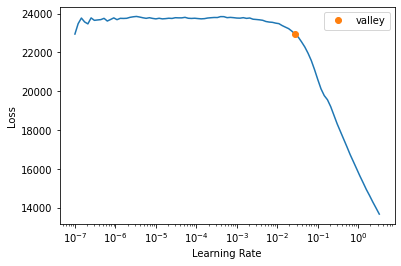

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  166.00     168.71
1  125.00     121.10
2  177.00     151.26
3  144.00     131.75
4  123.00     157.53
XGBoost RMSE:  20.684221


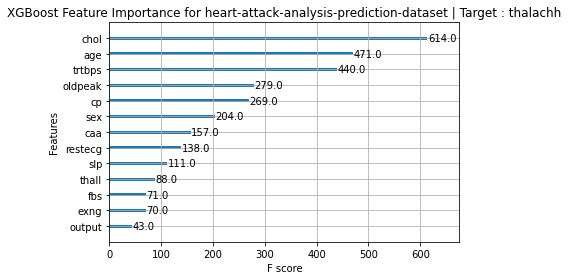

Target Variable: restecg
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


  5%|▍         | 2/42 [00:00<00:02, 19.74it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.014977204673016775, 'Adjusted R-Squared': -0.2633988027020002, 'RMSE': 0.4959658066727982, 'Time taken': 0.059430837631225586}
{'Model': 'BaggingRegressor', 'R-Squared': -0.23403781979977745, 'Adjusted R-Squared': -0.5827876384388448, 'RMSE': 0.5551276129563965, 'Time taken': 0.0417025089263916}
{'Model': 'BayesianRidge', 'R-Squared': 0.023359568104454165, 'Adjusted R-Squared': -0.25264751047472167, 'RMSE': 0.4938510088731485, 'Time taken': 0.015166997909545898}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.2024471635150165, 'Adjusted R-Squared': -1.824877883638825, 'RMSE': 0.7416198487095663, 'Time taken': 0.01352548599243164}
{'Model': 'DummyRegressor', 'R-Squared': -0.0006017963937650084, 'Adjusted R-Squared': -0.2833805649398289, 'RMSE': 0.4998724878956618, 'Time taken': 0.011665105819702148}
{'Model': 'ElasticNet', 'R-Squared': -0.0006018263081686293, 'Adjusted R-Squared': -0.28338060330830306, 'RMSE': 0.4998725, 'Time taken': 0.0

 21%|██▏       | 9/42 [00:00<00:01, 26.46it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.1502046718576191, 'Adjusted R-Squared': -0.4752625139043374, 'RMSE': 0.5359399842022115, 'Time taken': 0.15250349044799805}
{'Model': 'GammaRegressor', 'R-Squared': 0.024821952005921077, 'Adjusted R-Squared': -0.2507718441663185, 'RMSE': 0.49348113358811424, 'Time taken': 0.014219284057617188}


 29%|██▊       | 12/42 [00:00<00:01, 21.22it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.596522675796873, 'Adjusted R-Squared': -6.178148649391641, 'RMSE': 1.182191219438316, 'Time taken': 0.031522512435913086}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.3573234936613441, 'Adjusted R-Squared': -0.7409149157830281, 'RMSE': 0.5821974227970622, 'Time taken': 0.14639544486999512}


 43%|████▎     | 18/42 [00:00<00:01, 19.01it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.230184057162391, 'Adjusted R-Squared': -0.5778447689691535, 'RMSE': 0.5542601343204665, 'Time taken': 0.18385910987854004}
{'Model': 'HuberRegressor', 'R-Squared': -0.027545728820240978, 'Adjusted R-Squared': -0.31793908696509154, 'RMSE': 0.5065579955305646, 'Time taken': 0.017370939254760742}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.09988876529477198, 'Adjusted R-Squared': -0.41072689461720735, 'RMSE': 0.5240865068542279, 'Time taken': 0.013155698776245117}
{'Model': 'KernelRidge', 'R-Squared': -9.058695531395307, 'Adjusted R-Squared': -11.901370355485284, 'RMSE': 1.5848911, 'Time taken': 0.02269577980041504}
{'Model': 'Lars', 'R-Squared': -0.019472456117625603, 'Adjusted R-Squared': -0.3075842371943458, 'RMSE': 0.5045641, 'Time taken': 0.03587770462036133}
{'Model': 'LarsCV', 'R-Squared': -0.0006018263081686293, 'Adjusted R-Squared': -0.28338060330830306, 'RMSE': 0.4998725, 'Time taken': 0.07887935638427734}
{'Model':

 55%|█████▍    | 23/42 [00:01<00:00, 25.66it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed -65.8800048828125 but the user-supplied value was -65.87995910644531.
{'Model': 'LassoLars', 'R-Squared': -0.0006018263081686293, 'Adjusted R-Squared': -0.28338060330830306, 'RMSE': 0.4998725, 'Time taken': 0.01425480842590332}
{'Model': 'LassoLarsCV', 'R-Squared': -0.0006018263081686293, 'Adjusted R-Squared': -0.28338060330830306, 'RMSE': 0.4998725, 'Time taken': 0.030706167221069336}
{'Model': 'LassoLarsIC', 'R-Squared': -0.0006018263081686293, 'Adjusted R-Squared': -0.28338060330830306, 'RMSE': 0.4998725, 'Time taken': 0.016452550888061523}
{'Model': 'LinearRegression', 'R-Squared': -0.01947259012862479, 'Adjusted R-Squared': -0.30758440907801865, 'RMSE': 0.50456417, 'Time taken': 0.01277613639831543}
{'Model': 'LinearSVR', 'R-Squared': -0.23191823215849405, 'Adjusted R-S

 69%|██████▉   | 29/42 [00:01<00:01, 11.39it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.42725410429713273, 'Adjusted R-Squared': -0.8306085250767572, 'RMSE': 0.59700674, 'Time taken': 0.8356709480285645}
{'Model': 'NuSVR', 'R-Squared': -0.03320348102800441, 'Adjusted R-Squared': -0.32519576914461434, 'RMSE': 0.5079506563535959, 'Time taken': 0.06007266044616699}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.018992505772151835, 'Adjusted R-Squared': -0.30696864870775986, 'RMSE': 0.5044453121689332, 'Time taken': 0.02862381935119629}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.018992505772151835, 'Adjusted R-Squared': -0.30696864870775986, 'RMSE': 0.5044453121689332, 'Time taken': 0.028894901275634766}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.5092635452001626, 'Adjusted R-Squared': -2.21840324275673, 'RMSE': 0.7915926153322782, 'Time taken': 0.012094497680664062}
{'Model': 'PoissonRegressor', 'R-Squared': 0.02014218145206048, 'Adjusted R-Squared': -0.2567741585723571, 'RMSE': 0.49466379684550443,

 76%|███████▌  | 32/42 [00:04<00:02,  3.77it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.9354838709327964, 'Adjusted R-Squared': -1.4824684431529342, 'RMSE': 0.6952217871475309, 'Time taken': 2.105806589126587}
{'Model': 'RANSACRegressor', 'R-Squared': -0.7705372018864829, 'Adjusted R-Squared': -1.2709064111152713, 'RMSE': 0.6649379, 'Time taken': 0.16233062744140625}


 81%|████████  | 34/42 [00:04<00:01,  4.02it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.11363070077864279, 'Adjusted R-Squared': -0.4283524205639113, 'RMSE': 0.5273502947124742, 'Time taken': 0.20643043518066406}
{'Model': 'Ridge', 'R-Squared': -0.018683811084049262, 'Adjusted R-Squared': -0.3065727142164978, 'RMSE': 0.5043689, 'Time taken': 0.013395071029663086}
{'Model': 'RidgeCV', 'R-Squared': -0.012362652722536227, 'Adjusted R-Squared': -0.2984651415354269, 'RMSE': 0.5028016023568894, 'Time taken': 0.012580394744873047}
{'Model': 'SGDRegressor', 'R-Squared': -0.007008517876634812, 'Adjusted R-Squared': -0.2915978816243794, 'RMSE': 0.5014702432655996, 'Time taken': 0.012558698654174805}
{'Model': 'SVR', 'R-Squared': -0.21281815005535454, 'Adjusted R-Squared': -0.5555711055057808, 'RMSE': 0.5503341199519323, 'Time taken': 0.0188901424407959}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.01947259012862479, 'Adjusted R-Squared': -0.30758440907801865, 'RMSE': 0.50456417, 'Time taken': 0.01277017593383789}
{'Model

100%|██████████| 42/42 [00:05<00:00,  8.20it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.4722853440906791, 'Adjusted R-Squared': -0.8883659848119578, 'RMSE': 0.6063517, 'Time taken': 0.4851861000061035}
{'Model': 'LGBMRegressor', 'R-Squared': -0.23075566402660552, 'Adjusted R-Squared': -0.5785779169036895, 'RMSE': 0.5543888882664503, 'Time taken': 0.04689836502075195}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: restecg
restecg
Target Standard Deviation: 0.5312449150409321
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GammaRegressor                              -0.25       0.02  0.49        0.01
TweedieRegressor                            -0.25       0.02  0.49        0.01
BayesianRidge                               -0.25       0.02  0.49        0.02
PoissonRegressor                            -0.26       0.02  0.49        0.01
AdaBoostRegressor                        

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,8.365929,3.776724,1.943379,00:00
1,5.904849,4.030044,2.007497,00:00


Better model found at epoch 0 with _rmse value: 1.9433794021606445.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.46
1       2       1.62
2       2       1.63
3       1       1.08
4       2       1.32
XGBoost RMSE:  0.60339564


<Figure size 432x288 with 0 Axes>

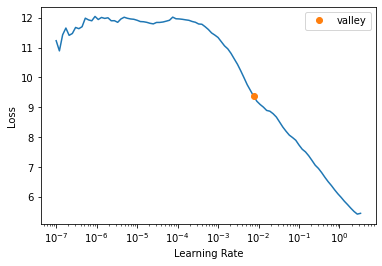

<Figure size 720x720 with 0 Axes>

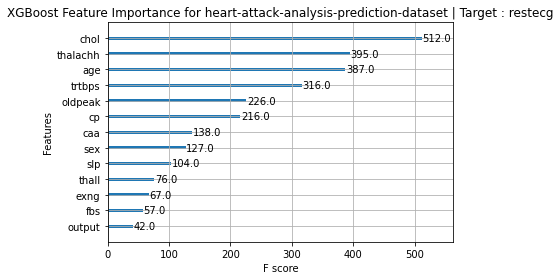

Target Variable: fbs
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


 14%|█▍        | 6/42 [00:00<00:00, 54.43it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.12357304594940732, 'Adjusted R-Squared': -0.44110455893510925, 'RMSE': 0.4101510127605884, 'Time taken': 0.02666926383972168}
{'Model': 'BaggingRegressor', 'R-Squared': -0.27792207792207746, 'Adjusted R-Squared': -0.6390739695087515, 'RMSE': 0.4374166587286466, 'Time taken': 0.034821271896362305}
{'Model': 'BayesianRidge', 'R-Squared': 0.03086965849261969, 'Adjusted R-Squared': -0.24301500323772673, 'RMSE': 0.3809203963474077, 'Time taken': 0.013088226318359375}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.669758812615955, 'Adjusted R-Squared': -1.1416471727030726, 'RMSE': 0.5, 'Time taken': 0.01253819465637207}
{'Model': 'DummyRegressor', 'R-Squared': -0.012256353324000768, 'Adjusted R-Squared': -0.2983288010025227, 'RMSE': 0.38930357136588456, 'Time taken': 0.010985136032104492}
{'Model': 'ElasticNet', 'R-Squared': -0.01225633077420163, 'Adjusted R-Squared': -0.2983287720799541, 'RMSE': 0.38930357, 'Time taken': 0.01174449920654296

 29%|██▊       | 12/42 [00:00<00:01, 21.55it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.2716671084425615, 'Adjusted R-Squared': -0.6310512912632853, 'RMSE': 0.4363448468848097, 'Time taken': 0.16975665092468262}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.1692852955241222, 'Adjusted R-Squared': -0.4997354877374609, 'RMSE': 0.41841127238357173, 'Time taken': 0.17133855819702148}


 45%|████▌     | 19/42 [00:00<00:01, 18.81it/s]

{'Model': 'HuberRegressor', 'R-Squared': -0.22448979374747302, 'Adjusted R-Squared': -0.5705412571978457, 'RMSE': 0.42817441890928315, 'Time taken': 0.053827524185180664}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.13098330241187361, 'Adjusted R-Squared': -0.4506090183108813, 'RMSE': 0.4115013163202924, 'Time taken': 0.013929605484008789}
{'Model': 'KernelRidge', 'R-Squared': -9.270566772220304, 'Adjusted R-Squared': -12.173118251326041, 'RMSE': 1.2400532, 'Time taken': 0.03701448440551758}
{'Model': 'Lars', 'R-Squared': 0.07820089697172128, 'Adjusted R-Squared': -0.1823075451884444, 'RMSE': 0.3715021, 'Time taken': 0.06932616233825684}
{'Model': 'LarsCV', 'R-Squared': -0.01225633077420163, 'Adjusted R-Squared': -0.2983287720799541, 'RMSE': 0.38930357, 'Time taken': 0.0628349781036377}
{'Model': 'Lasso', 'R-Squared': -0.01225633077420163, 'Adjusted R-Squared': -0.2983287720799541, 'RMSE': 0.38930357, 'Time taken': 0.012718677520751953}


 60%|█████▉    | 25/42 [00:01<00:00, 26.45it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed -80.71466064453125 but the user-supplied value was -80.714599609375.
{'Model': 'LassoLars', 'R-Squared': -0.01225633077420163, 'Adjusted R-Squared': -0.2983287720799541, 'RMSE': 0.38930357, 'Time taken': 0.013622760772705078}
{'Model': 'LassoLarsCV', 'R-Squared': -0.01225633077420163, 'Adjusted R-Squared': -0.2983287720799541, 'RMSE': 0.38930357, 'Time taken': 0.029947757720947266}
{'Model': 'LassoLarsIC', 'R-Squared': 0.045548065118872105, 'Adjusted R-Squared': -0.2241883512605769, 'RMSE': 0.37802467, 'Time taken': 0.015856266021728516}
{'Model': 'LinearRegression', 'R-Squared': 0.07820082436837916, 'Adjusted R-Squared': -0.1823076383101223, 'RMSE': 0.3715021, 'Time taken': 0.011774778366088867}
{'Model': 'LinearSVR', 'R-Squared': -0.2244897959527019, 'Adjusted R-Squared': 

 69%|██████▉   | 29/42 [00:02<00:01, 10.15it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.4024794621569432, 'Adjusted R-Squared': -0.7988323536360793, 'RMSE': 0.4582383, 'Time taken': 0.8280727863311768}
{'Model': 'NuSVR', 'R-Squared': -0.24565301322070332, 'Adjusted R-Squared': -0.5976853865222063, 'RMSE': 0.43185870056907605, 'Time taken': 0.10551142692565918}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.03871830256832942, 'Adjusted R-Squared': -0.23294826409714253, 'RMSE': 0.37937479083489406, 'Time taken': 0.01439356803894043}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.054536810811667835, 'Adjusted R-Squared': -0.21265930787199117, 'RMSE': 0.37624041478101, 'Time taken': 0.01954340934753418}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.6063115314881726, 'Adjusted R-Squared': -1.0602691382130907, 'RMSE': 0.49040853589185246, 'Time taken': 0.01312565803527832}
{'Model': 'PoissonRegressor', 'R-Squared': 0.05174137075567775, 'Adjusted R-Squared': -0.21624476359597855, 'RMSE': 0.37679621708804123, 'Ti

 76%|███████▌  | 32/42 [00:03<00:01,  5.15it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.2244897958784111, 'Adjusted R-Squared': -0.5705412599310056, 'RMSE': 0.42817441928185185, 'Time taken': 1.4504611492156982}
{'Model': 'RANSACRegressor', 'R-Squared': -0.22448979591836693, 'Adjusted R-Squared': -0.5705412599822532, 'RMSE': 0.42817444, 'Time taken': 0.11324167251586914}


 81%|████████  | 34/42 [00:03<00:01,  5.34it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.1690426716140998, 'Adjusted R-Squared': -0.4994242962006932, 'RMSE': 0.4183678604609425, 'Time taken': 0.1989123821258545}
{'Model': 'Ridge', 'R-Squared': 0.07805398942808173, 'Adjusted R-Squared': -0.1824959700813733, 'RMSE': 0.37153172, 'Time taken': 0.014321565628051758}
{'Model': 'RidgeCV', 'R-Squared': 0.07669807616034452, 'Adjusted R-Squared': -0.18423507622912316, 'RMSE': 0.3718048087630474, 'Time taken': 0.012230634689331055}
{'Model': 'SGDRegressor', 'R-Squared': 0.07374097374095856, 'Adjusted R-Squared': -0.1880278815061618, 'RMSE': 0.37239973115577757, 'Time taken': 0.01202702522277832}
{'Model': 'SVR', 'R-Squared': -0.17874102654859092, 'Adjusted R-Squared': -0.5118634905731927, 'RMSE': 0.4200996618891267, 'Time taken': 0.0162198543548584}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.07820082436837916, 'Adjusted R-Squared': -0.1823076383101223, 'RMSE': 0.3715021, 'Time taken': 0.01244974136352539}
{'Model': 'Tweed

100%|██████████| 42/42 [00:04<00:00,  9.51it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.39029467950191465, 'Adjusted R-Squared': -0.7832040454481077, 'RMSE': 0.45624337, 'Time taken': 0.4732849597930908}
{'Model': 'LGBMRegressor', 'R-Squared': -0.14330911954374836, 'Adjusted R-Squared': -0.46641821854524235, 'RMSE': 0.41373757632709934, 'Time taken': 0.04735922813415527}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: fbs
fbs
Target Standard Deviation: 0.3475007610186551
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                        -0.18       0.08  0.37        0.07
LinearRegression                            -0.18       0.08  0.37        0.01
TransformedTargetRegressor                  -0.18       0.08  0.37        0.01
Ridge                                       -0.18       0.08  0.37        0.01
RidgeCV                                     -

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,6.768561,1.939296,1.392586,00:00
1,6.384159,1.794756,1.339685,00:00
2,5.789960,2.040839,1.428579,00:00


Better model found at epoch 0 with _rmse value: 1.3925861120224.
Better model found at epoch 1 with _rmse value: 1.3396849632263184.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       0.99
1       1       1.22
2       1       0.91
3       1       1.07
4       1       0.96
XGBoost RMSE:  0.44958594


<Figure size 432x288 with 0 Axes>

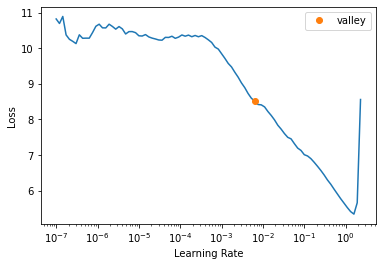

<Figure size 720x720 with 0 Axes>

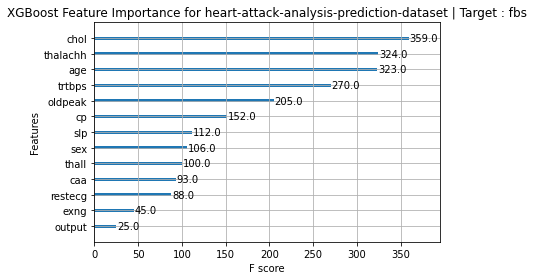

Target Variable: chol
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'thalachh', 'oldpeak']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


  2%|▏         | 1/42 [00:00<00:04,  9.95it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.15279790486137124, 'Adjusted R-Squared': -0.47858861710480216, 'RMSE': 44.36802031790562, 'Time taken': 0.10038566589355469}
{'Model': 'BaggingRegressor', 'R-Squared': -0.4008900700138214, 'Adjusted R-Squared': -0.79679378545251, 'RMSE': 48.90975533231245, 'Time taken': 0.03836393356323242}
{'Model': 'BayesianRidge', 'R-Squared': 0.07424539813357656, 'Adjusted R-Squared': -0.18738090239389082, 'RMSE': 39.75954462225258, 'Time taken': 0.012965679168701172}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -2.354204582328205, 'Adjusted R-Squared': -3.302131964290523, 'RMSE': 75.68123941902643, 'Time taken': 0.01259922981262207}
{'Model': 'DummyRegressor', 'R-Squared': -0.0007116131095705747, 'Adjusted R-Squared': -0.2835214168144491, 'RMSE': 41.337856, 'Time taken': 0.011269330978393555}


 17%|█▋        | 7/42 [00:00<00:00, 36.19it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.07610685415071994, 'Adjusted R-Squared': -0.18499338271972876, 'RMSE': 39.71955, 'Time taken': 0.014190673828125}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 40.050514221191406 but the user-supplied value was 40.05049514770508.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.8856335465386214, 'Adjusted R-Squared': -2.7011386792560574, 'RMSE': 70.19627245564159, 'Time taken': 0.014392614364624023}


 26%|██▌       | 11/42 [00:00<00:01, 23.17it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.5710201208692722, 'Adjusted R-Squared': -1.0150040680714576, 'RMSE': 51.794582358260854, 'Time taken': 0.17219185829162598}
{'Model': 'GammaRegressor', 'R-Squared': 0.08073411226212834, 'Adjusted R-Squared': -0.17905842122900917, 'RMSE': 39.61996012724201, 'Time taken': 0.015438079833984375}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -19.5875185264619, 'Adjusted R-Squared': -25.40573028394026, 'RMSE': 187.49749219790357, 'Time taken': 0.041881561279296875}


 33%|███▎      | 14/42 [00:00<00:01, 14.72it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.2741353531543018, 'Adjusted R-Squared': -0.634217083393561, 'RMSE': 46.644586230502526, 'Time taken': 0.14857006072998047}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.3753033391100731, 'Adjusted R-Squared': -0.7639760219020502, 'RMSE': 48.46103782159449, 'Time taken': 0.18386626243591309}
{'Model': 'HuberRegressor', 'R-Squared': 0.02371321901885015, 'Adjusted R-Squared': -0.25219391473669206, 'RMSE': 40.83026196491224, 'Time taken': 0.01979851722717285}


 43%|████▎     | 18/42 [00:00<00:01, 17.52it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': -0.3455871078942896, 'Adjusted R-Squared': -0.7258617253426756, 'RMSE': 47.93463, 'Time taken': 0.015526533126831055}
{'Model': 'KernelRidge', 'R-Squared': -35.75630685560569, 'Adjusted R-Squared': -46.143958793059475, 'RMSE': 250.5298, 'Time taken': 0.026443004608154297}
{'Model': 'Lars', 'R-Squared': 0.0017466258680030045, 'Adjusted R-Squared': -0.2803684581258221, 'RMSE': 41.28705, 'Time taken': 0.03639650344848633}
{'Model': 'LarsCV', 'R-Squared': 0.041872133126058086, 'Adjusted R-Squared': -0.22890313359918624, 'RMSE': 40.448757, 'Time taken': 0.07950973510742188}
{'Model': 'Lasso', 'R-Squared': 0.03548665978460053, 'Adjusted R-Squared': -0.23709319723279498, 'RMSE': 40.58332, 'Time taken': 0.013025045394897461}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 40.050514221

 55%|█████▍    | 23/42 [00:01<00:00, 23.64it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.041872133126058086, 'Adjusted R-Squared': -0.22890313359918624, 'RMSE': 40.448757, 'Time taken': 0.03242206573486328}
{'Model': 'LassoLarsIC', 'R-Squared': 0.04740823798503413, 'Adjusted R-Squared': -0.2218024773670213, 'RMSE': 40.33173, 'Time taken': 0.017810344696044922}
{'Model': 'LinearRegression', 'R-Squared': 0.0017467572528254705, 'Adjusted R-Squared': -0.2803682896105064, 'RMSE': 41.28705, 'Time taken': 0.012745380401611328}
{'Model': 'LinearSVR', 'R-Squared': -1.771159942296889, 'Adjusted R-Squared': -2.554313839032966, 'RMSE': 68.78983347900657, 'Time taken': 0.012534856796264648}


 64%|██████▍   | 27/42 [00:01<00:01, 10.18it/s]

{'Model': 'MLPRegressor', 'R-Squared': -19.11409977121431, 'Adjusted R-Squared': -24.798519271774875, 'RMSE': 185.32916, 'Time taken': 0.8022680282592773}
{'Model': 'NuSVR', 'R-Squared': -0.0009030035224397714, 'Adjusted R-Squared': -0.28376689582225967, 'RMSE': 41.341807277827456, 'Time taken': 0.04247736930847168}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.00021836239489614329, 'Adjusted R-Squared': -0.28232862214567667, 'RMSE': 41.31864205329232, 'Time taken': 0.02875518798828125}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.0059392305413332735, 'Adjusted R-Squared': -0.29022640438997094, 'RMSE': 41.44568621282989, 'Time taken': 0.03833723068237305}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.1539628738036516, 'Adjusted R-Squared': -0.4800828164003357, 'RMSE': 44.39043288207183, 'Time taken': 0.012488842010498047}
{'Model': 'PoissonRegressor', 'R-Squared': 0.0034774360010424443, 'Adjusted R-Squared': -0.2781485059986628, 'RMSE': 41.251242127648474,

 76%|███████▌  | 32/42 [00:04<00:02,  4.05it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04115726755425353, 'Adjusted R-Squared': -0.3353973649065425, 'RMSE': 42.164953851889784, 'Time taken': 2.4416844844818115}
{'Model': 'RANSACRegressor', 'R-Squared': -0.8778412519339742, 'Adjusted R-Squared': -1.40853551878488, 'RMSE': 56.626915, 'Time taken': 0.15232586860656738}


 81%|████████  | 34/42 [00:04<00:01,  4.22it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.18278379132410327, 'Adjusted R-Squared': -0.517048775828741, 'RMSE': 44.94135309860322, 'Time taken': 0.2230069637298584}
{'Model': 'Ridge', 'R-Squared': 0.003329002818622917, 'Adjusted R-Squared': -0.2783388876891575, 'RMSE': 41.254314, 'Time taken': 0.014847755432128906}
{'Model': 'RidgeCV', 'R-Squared': 0.016108548244770926, 'Adjusted R-Squared': -0.2619477315990981, 'RMSE': 40.98897475160679, 'Time taken': 0.013366937637329102}
{'Model': 'SGDRegressor', 'R-Squared': -0.0022612338689804723, 'Adjusted R-Squared': -0.2855089738754315, 'RMSE': 41.3698482870008, 'Time taken': 0.013777971267700195}
{'Model': 'SVR', 'R-Squared': -0.029767055454981595, 'Adjusted R-Squared': -0.3207881798226937, 'RMSE': 41.933678258967475, 'Time taken': 0.017592191696166992}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.0017467572528254705, 'Adjusted R-Squared': -0.2803682896105064, 'RMSE': 41.28705, 'Time taken': 0.014146089553833008}
{'Model': 'T

 98%|█████████▊| 41/42 [00:05<00:00,  5.96it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.4588564838752698, 'Adjusted R-Squared': -0.8711420119269764, 'RMSE': 49.9114, 'Time taken': 0.5170433521270752}


100%|██████████| 42/42 [00:05<00:00,  7.34it/s]

{'Model': 'LGBMRegressor', 'R-Squared': -0.35710440771137875, 'Adjusted R-Squared': -0.7406339142385074, 'RMSE': 48.13933563986733, 'Time taken': 0.2363574504852295}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: chol
chol
Target Standard Deviation: 53.92414474487305
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
GammaRegressor                              -0.18       0.08  39.62   
TweedieRegressor                            -0.18       0.08  39.63   
ElasticNet                                  -0.18       0.08  39.72   
BayesianRidge                               -0.19       0.07  39.76   
LassoLarsIC                                 -0.22       0.05  40.33   
LassoLarsCV                                 -0.23       0.04  40.45   
LarsCV                                      -0.23       0.04  40.45   
Lasso                                    

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,62853.523438,62376.964844,249.753815,00:00
1,61555.265625,59539.628906,244.007431,00:00
2,59835.148438,52140.890625,228.343796,00:00
3,55659.718750,23538.917969,153.423981,00:00
4,48159.320312,27430.873047,165.622681,00:00


Better model found at epoch 0 with _rmse value: 249.75381469726562.
Better model found at epoch 1 with _rmse value: 244.00743103027344.
Better model found at epoch 2 with _rmse value: 228.3437957763672.
Better model found at epoch 3 with _rmse value: 153.42398071289062.
No improvement since epoch 3: early stopping


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age,trtbps,thalachh,oldpeak,chol,chol_pred
0,1.00,3.00,1.00,2.00,1.00,3.00,1.00,3.00,2.00,-0.68,-0.10,-0.48,-0.70,275.00,88.43
1,2.00,1.00,2.00,1.00,2.00,3.00,4.00,4.00,1.00,0.95,-0.10,-0.78,0.68,330.00,85.90
2,2.00,4.00,1.00,1.00,1.00,2.00,1.00,4.00,1.00,0.51,2.14,0.38,-0.70,288.00,104.16
3,2.00,3.00,2.00,1.00,1.00,1.00,1.00,3.00,2.00,-0.14,-0.10,0.08,0.16,197.00,86.80
4,2.00,1.00,1.00,2.00,2.00,2.00,1.00,2.00,2.00,0.30,-1.23,-1.04,0.42,201.00,97.20
5,2.00,1.00,2.00,2.00,1.00,2.00,3.00,4.00,1.00,1.38,-0.38,0.55,-0.70,254.00,161.38
6,2.00,3.00,1.00,2.00,1.00,3.00,1.00,3.00,1.00,1.06,0.46,0.34,-0.87,335.00,90.55
7,2.00,1.00,1.00,1.00,2.00,3.00,1.00,4.00,1.00,-2.08,-0.33,0.25,-0.87,282.00,86.19
8,1.00,1.00,1.00,1.00,1.00,3.00,2.00,3.00,2.00,0.30,-0.22,0.38,-0.87,303.00,88.14


<Figure size 432x288 with 0 Axes>

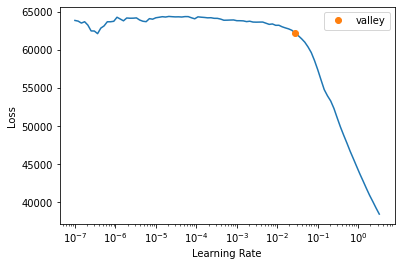

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  245.00     235.30
1  330.00     203.02
2  266.00     210.11
3  220.00     263.21
4  307.00     308.94
XGBoost RMSE:  49.58051


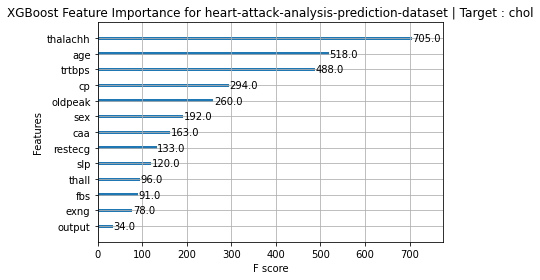

Target Variable: trtbps
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'chol', 'thalachh', 'oldpeak']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


 17%|█▋        | 7/42 [00:00<00:01, 34.48it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.11991735783352064, 'Adjusted R-Squared': -0.12880164973526687, 'RMSE': 15.681852989060587, 'Time taken': 0.10206222534179688}
{'Model': 'BaggingRegressor', 'R-Squared': 0.011181331449621634, 'Adjusted R-Squared': -0.2682674227059201, 'RMSE': 16.622409572622136, 'Time taken': 0.03806614875793457}
{'Model': 'BayesianRidge', 'R-Squared': 0.1375729763966066, 'Adjusted R-Squared': -0.10615639983913505, 'RMSE': 15.52375674010935, 'Time taken': 0.012448787689208984}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.8324280600572151, 'Adjusted R-Squared': -1.350288163986428, 'RMSE': 22.62815355554521, 'Time taken': 0.012665510177612305}
{'Model': 'DummyRegressor', 'R-Squared': -0.001199974133963444, 'Adjusted R-Squared': -0.28414779291095305, 'RMSE': 16.726152, 'Time taken': 0.010936498641967773}
{'Model': 'ElasticNet', 'R-Squared': 0.11706211161004865, 'Adjusted R-Squared': -0.13246381336972024, 'RMSE': 15.707271, 'Time taken': 0.0117685794830322

 26%|██▌       | 11/42 [00:00<00:01, 22.58it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.03161874957509847, 'Adjusted R-Squared': -0.24205421250150416, 'RMSE': 16.44973236864357, 'Time taken': 0.17100310325622559}
{'Model': 'GammaRegressor', 'R-Squared': 0.12146622204131474, 'Adjusted R-Squared': -0.12681506303396572, 'RMSE': 15.668047605518916, 'Time taken': 0.01423192024230957}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -29.881832033004084, 'Adjusted R-Squared': -38.60930630320089, 'RMSE': 92.89389621266994, 'Time taken': 0.04825997352600098}


 33%|███▎      | 14/42 [00:00<00:01, 14.40it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.18848091936687772, 'Adjusted R-Squared': -0.5243559617966473, 'RMSE': 18.223498580733683, 'Time taken': 0.16197633743286133}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.05654589950842559, 'Adjusted R-Squared': -0.3551349580651544, 'RMSE': 17.182242134434784, 'Time taken': 0.176544189453125}
{'Model': 'HuberRegressor', 'R-Squared': 0.08068145479842215, 'Adjusted R-Squared': -0.17912596014984983, 'RMSE': 16.02760611838621, 'Time taken': 0.020475149154663086}


 43%|████▎     | 18/42 [00:00<00:01, 17.44it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': -0.07055976380226325, 'Adjusted R-Squared': -0.37310926226812025, 'RMSE': 17.295818, 'Time taken': 0.017203330993652344}
{'Model': 'KernelRidge', 'R-Squared': -63.29550092840741, 'Adjusted R-Squared': -81.46596858208775, 'RMSE': 134.03738, 'Time taken': 0.02121138572692871}
{'Model': 'Lars', 'R-Squared': 0.13577015027880823, 'Adjusted R-Squared': -0.108468720294572, 'RMSE': 15.539973, 'Time taken': 0.033612728118896484}
{'Model': 'LarsCV', 'R-Squared': 0.11303519497691461, 'Adjusted R-Squared': -0.13762877166004417, 'RMSE': 15.743049, 'Time taken': 0.07892227172851562}
{'Model': 'Lasso', 'R-Squared': 0.11268510973376644, 'Adjusted R-Squared': -0.1380777940371256, 'RMSE': 15.746156, 'Time taken': 0.015414714813232422}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed 29.788223266

 55%|█████▍    | 23/42 [00:01<00:00, 23.05it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.11303519497691461, 'Adjusted R-Squared': -0.13762877166004417, 'RMSE': 15.743049, 'Time taken': 0.03351116180419922}
{'Model': 'LassoLarsIC', 'R-Squared': 0.11204689714386262, 'Adjusted R-Squared': -0.13889637105461095, 'RMSE': 15.751817, 'Time taken': 0.016312837600708008}
{'Model': 'LinearRegression', 'R-Squared': 0.13577016713964796, 'Adjusted R-Squared': -0.10846869866871223, 'RMSE': 15.539974, 'Time taken': 0.012743234634399414}
{'Model': 'LinearSVR', 'R-Squared': -0.5210129035640443, 'Adjusted R-Squared': -0.9508643763104045, 'RMSE': 20.615890540038283, 'Time taken': 0.01180267333984375}


 69%|██████▉   | 29/42 [00:02<00:01, 11.54it/s]

{'Model': 'MLPRegressor', 'R-Squared': -18.937364954911, 'Adjusted R-Squared': -24.571837659559762, 'RMSE': 74.63964, 'Time taken': 0.811957597732544}
{'Model': 'NuSVR', 'R-Squared': 0.03645370614086407, 'Adjusted R-Squared': -0.2358528551671526, 'RMSE': 16.40861567799442, 'Time taken': 0.0427858829498291}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.13342190700478274, 'Adjusted R-Squared': -0.11148059753734385, 'RMSE': 15.561071686298364, 'Time taken': 0.030684232711791992}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.09415015584644804, 'Adjusted R-Squared': -0.1618508870665123, 'RMSE': 15.909764729338905, 'Time taken': 0.03533148765563965}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.03630140466871956, 'Adjusted R-Squared': -0.32916919294466207, 'RMSE': 17.016831318002943, 'Time taken': 0.012402534484863281}
{'Model': 'PoissonRegressor', 'R-Squared': 0.1368340549092718, 'Adjusted R-Squared': -0.10710414696419468, 'RMSE': 15.530405639740337, 'Time taken'

 76%|███████▌  | 32/42 [00:03<00:02,  4.80it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.015285152067779029, 'Adjusted R-Squared': -0.302213564608673, 'RMSE': 16.843396333047814, 'Time taken': 1.5346601009368896}
{'Model': 'RANSACRegressor', 'R-Squared': -0.5314572197424381, 'Adjusted R-Squared': -0.964260347060953, 'RMSE': 20.686552, 'Time taken': 0.16067218780517578}


 81%|████████  | 34/42 [00:04<00:01,  4.88it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.0918546835924332, 'Adjusted R-Squared': -0.16479507974013985, 'RMSE': 15.929910075075753, 'Time taken': 0.2216510772705078}
{'Model': 'Ridge', 'R-Squared': 0.13618418186112524, 'Adjusted R-Squared': -0.10793767978681745, 'RMSE': 15.53625, 'Time taken': 0.014925003051757812}
{'Model': 'RidgeCV', 'R-Squared': 0.13912781696415488, 'Adjusted R-Squared': -0.10416214780684485, 'RMSE': 15.50975679876492, 'Time taken': 0.01229715347290039}
{'Model': 'SGDRegressor', 'R-Squared': 0.1370373550743732, 'Adjusted R-Squared': -0.10684339240460816, 'RMSE': 15.52857660560094, 'Time taken': 0.012987613677978516}
{'Model': 'SVR', 'R-Squared': 0.03982984884697194, 'Adjusted R-Squared': -0.23152258517453594, 'RMSE': 16.379843609430345, 'Time taken': 0.01761031150817871}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.13577016713964796, 'Adjusted R-Squared': -0.10846869866871223, 'RMSE': 15.539974, 'Time taken': 0.01386117935180664}
{'Model': 'Tweedie

100%|██████████| 42/42 [00:04<00:00,  9.06it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.24270138290892818, 'Adjusted R-Squared': -0.593899599817973, 'RMSE': 18.634556, 'Time taken': 0.48366785049438477}
{'Model': 'LGBMRegressor', 'R-Squared': -0.10836119507054254, 'Adjusted R-Squared': -0.42159370672091323, 'RMSE': 17.598526504652508, 'Time taken': 0.05161547660827637}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: trtbps
trtbps
Target Standard Deviation: 17.72942543029785
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
RidgeCV                                     -0.10       0.14  15.51   
BayesianRidge                               -0.11       0.14  15.52   
SGDRegressor                                -0.11       0.14  15.53   
PoissonRegressor                            -0.11       0.14  15.53   
Ridge                                       -0.11       0.14  15.54   
TransformedTargetRe

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,18117.570312,17621.070312,132.744385,00:00
1,17640.285156,16666.115234,129.097305,00:00
2,16411.900391,13440.738281,115.934196,00:00
3,14475.269531,4248.295410,65.178947,00:00
4,11794.913086,8982.360352,94.775314,00:00


Better model found at epoch 0 with _rmse value: 132.744384765625.
Better model found at epoch 1 with _rmse value: 129.09730529785156.
Better model found at epoch 2 with _rmse value: 115.93419647216797.
Better model found at epoch 3 with _rmse value: 65.17894744873047.
No improvement since epoch 3: early stopping


,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age,chol,thalachh,oldpeak,trtbps,trtbps_pred
0,2.00,2.00,1.00,2.00,1.00,3.00,1.00,4.00,2.00,-1.20,0.30,1.03,-0.90,120.00,163.48
1,2.00,4.00,1.00,1.00,1.00,2.00,1.00,4.00,2.00,1.05,-0.38,0.25,-0.39,170.00,56.81
2,1.00,2.00,1.00,2.00,1.00,3.00,1.00,3.00,2.00,0.03,1.80,0.73,0.12,132.00,98.74
3,1.00,4.00,1.00,2.00,1.00,3.00,1.00,3.00,2.00,0.60,-0.13,0.94,-0.13,150.00,61.99
4,2.00,1.00,1.00,1.00,2.00,2.00,3.00,4.00,1.00,0.37,0.23,-0.83,1.66,128.00,63.07
5,1.00,1.00,2.00,1.00,2.00,2.00,1.00,4.00,1.00,-1.32,1.78,-0.57,1.66,132.00,56.11
6,2.00,1.00,1.00,2.00,2.00,2.00,3.00,4.00,1.00,-0.98,1.21,-1.26,0.64,140.00,108.13
7,1.00,2.00,1.00,2.00,1.00,3.00,1.00,3.00,2.00,-0.98,-0.81,0.99,-0.90,105.00,128.36
8,2.00,2.00,1.00,1.00,1.00,3.00,2.00,3.00,1.00,0.26,-0.28,0.64,-0.90,154.00,55.84


<Figure size 432x288 with 0 Axes>

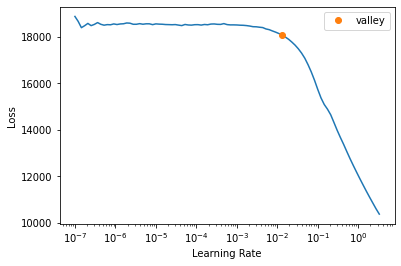

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  138.00     107.15
1  110.00     139.72
2  125.00     123.40
3  110.00     121.97
4  120.00     112.92
XGBoost RMSE:  18.553183


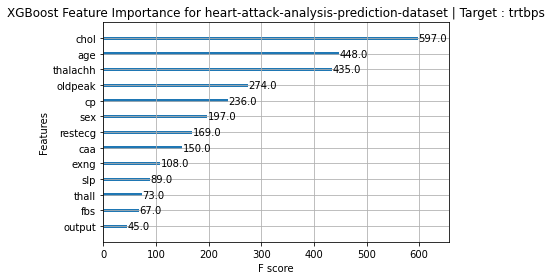

Target Variable: cp
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


 10%|▉         | 4/42 [00:00<00:00, 39.23it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.01269246860093498, 'Adjusted R-Squared': -0.2663292250553224, 'RMSE': 0.9490225868279382, 'Time taken': 0.04203319549560547}
{'Model': 'BaggingRegressor', 'R-Squared': -0.1689403166869674, 'Adjusted R-Squared': -0.49929301488111033, 'RMSE': 1.0326341720732146, 'Time taken': 0.035028696060180664}
{'Model': 'BayesianRidge', 'R-Squared': 0.16882306024437055, 'Adjusted R-Squared': -0.06607477055613331, 'RMSE': 0.8707571848935537, 'Time taken': 0.012384414672851562}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.3203410475030455, 'Adjusted R-Squared': -1.9760896044060798, 'RMSE': 1.4548768561863463, 'Time taken': 0.012201309204101562}
{'Model': 'DummyRegressor', 'R-Squared': -0.06619357100482293, 'Adjusted R-Squared': -0.3675091454192294, 'RMSE': 0.9862076194499138, 'Time taken': 0.012408733367919922}
{'Model': 'ElasticNet', 'R-Squared': -0.06619362316183897, 'Adjusted R-Squared': -0.36750921231627154, 'RMSE': 0.98620766, 'Time taken': 0.011

 21%|██▏       | 9/42 [00:00<00:01, 28.72it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.1526632155907428, 'Adjusted R-Squared': -0.478415863475083, 'RMSE': 1.0254194263812246, 'Time taken': 0.1531219482421875}
{'Model': 'GammaRegressor', 'R-Squared': 0.13675894740288186, 'Adjusted R-Squared': -0.10720048050499931, 'RMSE': 0.8873937521267508, 'Time taken': 0.01601123809814453}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.9488857008879923, 'Adjusted R-Squared': -2.7822664424432944, 'RMSE': 1.640133856471288, 'Time taken': 0.03519868850708008}


 31%|███       | 13/42 [00:00<00:01, 16.04it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.031050748783120197, 'Adjusted R-Squared': -0.322434656047915, 'RMSE': 0.9698182331132077, 'Time taken': 0.1708984375}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.23138488967004212, 'Adjusted R-Squared': -0.5793849671854887, 'RMSE': 1.0598569056555096, 'Time taken': 0.1758732795715332}
{'Model': 'HuberRegressor', 'R-Squared': 0.16627595938154882, 'Adjusted R-Squared': -0.06934170427149167, 'RMSE': 0.8720903606009263, 'Time taken': 0.020417213439941406}


 40%|████      | 17/42 [00:00<00:01, 18.77it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.010475030450669887, 'Adjusted R-Squared': -0.2691733305089232, 'RMSE': 0.9500877152487904, 'Time taken': 0.013412952423095703}
{'Model': 'KernelRidge', 'R-Squared': -3.1953000779310186, 'Adjusted R-Squared': -4.380928360824567, 'RMSE': 1.9562837, 'Time taken': 0.040047645568847656}
{'Model': 'Lars', 'R-Squared': 0.19131434716653783, 'Adjusted R-Squared': -0.037227250373353504, 'RMSE': 0.8588953, 'Time taken': 0.07753658294677734}
{'Model': 'LarsCV', 'R-Squared': 0.1518001028917384, 'Adjusted R-Squared': -0.08790856368233557, 'RMSE': 0.8796287, 'Time taken': 0.056951045989990234}
{'Model': 'Lasso', 'R-Squared': -0.06619362316183897, 'Adjusted R-Squared': -0.36750921231627154, 'RMSE': 0.98620766, 'Time taken': 0.012579679489135742}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we comput

 52%|█████▏    | 22/42 [00:00<00:00, 23.85it/s]

{'Model': 'LassoLars', 'R-Squared': -0.06619362316183897, 'Adjusted R-Squared': -0.36750921231627154, 'RMSE': 0.98620766, 'Time taken': 0.013313055038452148}
{'Model': 'LassoLarsCV', 'R-Squared': 0.1518001028917384, 'Adjusted R-Squared': -0.08790856368233557, 'RMSE': 0.8796287, 'Time taken': 0.029977083206176758}
{'Model': 'LassoLarsIC', 'R-Squared': 0.16103154900977235, 'Adjusted R-Squared': -0.07606823061790058, 'RMSE': 0.87482893, 'Time taken': 0.016394615173339844}
{'Model': 'LinearRegression', 'R-Squared': 0.19131451806841338, 'Adjusted R-Squared': -0.03722703117312198, 'RMSE': 0.8588951, 'Time taken': 0.012388229370117188}
{'Model': 'LinearSVR', 'R-Squared': -0.1692382722382375, 'Adjusted R-Squared': -0.49967517526208716, 'RMSE': 1.0327657696730834, 'Time taken': 0.012626409530639648}


 71%|███████▏  | 30/42 [00:02<00:01, 11.38it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.16796739998866594, 'Adjusted R-Squared': -0.49804514346372364, 'RMSE': 1.0322044, 'Time taken': 1.050715684890747}
{'Model': 'NuSVR', 'R-Squared': 0.10790100573307648, 'Adjusted R-Squared': -0.14421392742931483, 'RMSE': 0.902104498931461, 'Time taken': 0.03313183784484863}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.09299601927120027, 'Adjusted R-Squared': -0.16333119267389518, 'RMSE': 0.9096093594861627, 'Time taken': 0.020674705505371094}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.12560002765034872, 'Adjusted R-Squared': -0.12151300801368303, 'RMSE': 0.8931109034648768, 'Time taken': 0.03036355972290039}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.343532199223366, 'Adjusted R-Squared': -2.005834777264752, 'RMSE': 1.4621293207595798, 'Time taken': 0.018981456756591797}
{'Model': 'PoissonRegressor', 'R-Squared': 0.1519186273160852, 'Adjusted R-Squared': -0.08775654322502113, 'RMSE': 0.8795673222755569, 'Time t

 79%|███████▊  | 33/42 [00:04<00:02,  4.39it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.05968331303755403, 'Adjusted R-Squared': -0.3591590319394713, 'RMSE': 0.9831920802523403, 'Time taken': 1.7646665573120117}
{'Model': 'RANSACRegressor', 'R-Squared': -0.34368417059014233, 'Adjusted R-Squared': -0.7234210014090956, 'RMSE': 1.1071308, 'Time taken': 0.15321922302246094}


 83%|████████▎ | 35/42 [00:04<00:01,  4.86it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.04787880633373942, 'Adjusted R-Squared': -0.3440184689932744, 'RMSE': 0.9777005335650244, 'Time taken': 0.21207523345947266}
{'Model': 'Ridge', 'R-Squared': 0.19092436116892064, 'Adjusted R-Squared': -0.037727449805079916, 'RMSE': 0.8591023, 'Time taken': 0.013706684112548828}
{'Model': 'RidgeCV', 'R-Squared': 0.1873501298528676, 'Adjusted R-Squared': -0.0423117899713219, 'RMSE': 0.8609978341634881, 'Time taken': 0.015036821365356445}
{'Model': 'SGDRegressor', 'R-Squared': 0.19105233313409375, 'Adjusted R-Squared': -0.03756331184974915, 'RMSE': 0.8590343638818524, 'Time taken': 0.01297760009765625}
{'Model': 'SVR', 'R-Squared': 0.0035797908925995214, 'Adjusted R-Squared': -0.27801722472470924, 'RMSE': 0.9533921844755621, 'Time taken': 0.017756223678588867}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.19131451806841338, 'Adjusted R-Squared': -0.03722703117312198, 'RMSE': 0.8588951, 'Time taken': 0.012738943099975586}
{'Model':

100%|██████████| 42/42 [00:05<00:00,  8.39it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.25598506779792984, 'Adjusted R-Squared': -0.61093736956691, 'RMSE': 1.0703912, 'Time taken': 0.5165913105010986}
{'Model': 'LGBMRegressor', 'R-Squared': -0.28690529168050616, 'Adjusted R-Squared': -0.6505959175902143, 'RMSE': 1.0834867811682467, 'Time taken': 0.0544130802154541}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: cp
cp
Target Standard Deviation: 1.0424121936531032
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
TransformedTargetRegressor                  -0.04       0.19  0.86        0.01
LinearRegression                            -0.04       0.19  0.86        0.01
Lars                                        -0.04       0.19  0.86        0.08
SGDRegressor                                -0.04       0.19  0.86        0.01
Ridge                                       -0.04    

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,7.729376,6.588557,2.566818,00:00
1,6.894502,9.348615,3.057550,00:00


Better model found at epoch 0 with _rmse value: 2.5668184757232666.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.11
1       3       1.70
2       1       1.39
3       1       0.96
4       3       2.13
XGBoost RMSE:  1.0673057


<Figure size 432x288 with 0 Axes>

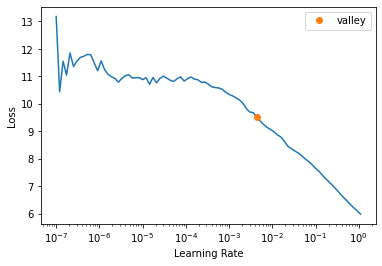

<Figure size 720x720 with 0 Axes>

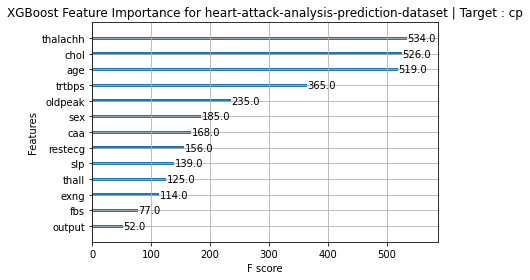

Target Variable: sex
CATS=====================
['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
CONTS=====================
['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
14
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Categorical variables that made the cut : ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
Tabular Object size: 302


  2%|▏         | 1/42 [00:00<00:05,  7.51it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.08606935421501039, 'Adjusted R-Squared': -0.3930019977975132, 'RMSE': 0.4696087904756387, 'Time taken': 0.13292312622070312}
{'Model': 'BaggingRegressor', 'R-Squared': -0.0629274965800275, 'Adjusted R-Squared': -0.3633200499613396, 'RMSE': 0.46457866215887844, 'Time taken': 0.03850269317626953}


 17%|█▋        | 7/42 [00:00<00:01, 34.46it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.07747958136810207, 'Adjusted R-Squared': -0.18323271085395598, 'RMSE': 0.4328081516291527, 'Time taken': 0.014975309371948242}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.641586867305062, 'Adjusted R-Squared': -1.1055135906738838, 'RMSE': 0.5773502691896257, 'Time taken': 0.013241767883300781}
{'Model': 'DummyRegressor', 'R-Squared': -0.009153781834290386, 'Adjusted R-Squared': -0.29434941583093766, 'RMSE': 0.45267458710573943, 'Time taken': 0.010861635208129883}
{'Model': 'ElasticNet', 'R-Squared': -0.009153768766758219, 'Adjusted R-Squared': -0.29434939907040714, 'RMSE': 0.4526746, 'Time taken': 0.011817455291748047}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (6,7) we computed -55.83657455444336 but the user-supplied value was -55.836544036865234.
{'Model': 'ExtraTreeRegressor', 

 26%|██▌       | 11/42 [00:00<00:01, 25.35it/s]

{'Model': 'GammaRegressor', 'R-Squared': 0.08611954295705049, 'Adjusted R-Squared': -0.17215102098987, 'RMSE': 0.4307766287952738, 'Time taken': 0.016812801361083984}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -6.963322421798195, 'Adjusted R-Squared': -9.213826584480293, 'RMSE': 1.2716119134493213, 'Time taken': 0.034955739974975586}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.058017453878625, 'Adjusted R-Squared': -0.20819500480785047, 'RMSE': 0.4373497333099821, 'Time taken': 0.14556169509887695}


 43%|████▎     | 18/42 [00:00<00:01, 18.55it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.08804035673989197, 'Adjusted R-Squared': -0.39553002277507865, 'RMSE': 0.47003472116928086, 'Time taken': 0.1799907684326172}
{'Model': 'HuberRegressor', 'R-Squared': 0.0468883979335164, 'Adjusted R-Squared': -0.22246922873744635, 'RMSE': 0.43992568220559186, 'Time taken': 0.01862788200378418}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.007934336525308172, 'Adjusted R-Squared': -0.2927853446737647, 'RMSE': 0.45240100206196127, 'Time taken': 0.014024734497070312}
{'Model': 'KernelRidge', 'R-Squared': -15.28576703502118, 'Adjusted R-Squared': -19.888266414483688, 'RMSE': 1.8184927, 'Time taken': 0.01992344856262207}
{'Model': 'Lars', 'R-Squared': 0.02197055017252947, 'Adjusted R-Squared': -0.2544290769526252, 'RMSE': 0.44563922, 'Time taken': 0.03380942344665527}
{'Model': 'LarsCV', 'R-Squared': 0.13974237925769217, 'Adjusted R-Squared': -0.10337390486513387, 'RMSE': 0.41794747, 'Time taken': 0.0788111686706543}
{'Model': 'L

 60%|█████▉    | 25/42 [00:01<00:00, 28.40it/s]

{'Model': 'LassoLars', 'R-Squared': -0.009153768766758219, 'Adjusted R-Squared': -0.29434939907040714, 'RMSE': 0.4526746, 'Time taken': 0.01276087760925293}
{'Model': 'LassoLarsCV', 'R-Squared': 0.13974237925769217, 'Adjusted R-Squared': -0.10337390486513387, 'RMSE': 0.41794747, 'Time taken': 0.030349016189575195}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0544786331229159, 'Adjusted R-Squared': -0.21273392708147743, 'RMSE': 0.4381705, 'Time taken': 0.015613079071044922}
{'Model': 'LinearRegression', 'R-Squared': 0.021970570123981625, 'Adjusted R-Squared': -0.2544290513627192, 'RMSE': 0.44563922, 'Time taken': 0.011508464813232422}
{'Model': 'LinearSVR', 'R-Squared': -0.3949343560374592, 'Adjusted R-Squared': -0.7891549349176106, 'RMSE': 0.5322115844555785, 'Time taken': 0.01320791244506836}


 69%|██████▉   | 29/42 [00:01<00:01, 10.82it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.12254684085469769, 'Adjusted R-Squared': -0.43978833935711226, 'RMSE': 0.47742996, 'Time taken': 0.8223018646240234}
{'Model': 'NuSVR', 'R-Squared': -0.1147377484172254, 'Adjusted R-Squared': -0.42977232949165867, 'RMSE': 0.47576642673018527, 'Time taken': 0.05489373207092285}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.062665273672454, 'Adjusted R-Squared': -0.2022336707244612, 'RMSE': 0.43626943921841976, 'Time taken': 0.027365684509277344}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.17514353846776853, 'Adjusted R-Squared': -0.057968070226122936, 'RMSE': 0.4092574825828075, 'Time taken': 0.03338980674743652}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5803849926446507, 'Adjusted R-Squared': -1.0270155340442257, 'RMSE': 0.5664856155924192, 'Time taken': 0.013275384902954102}
{'Model': 'PoissonRegressor', 'R-Squared': 0.09040483427641943, 'Adjusted R-Squared': -0.16665466908024462, 'RMSE': 0.42976546127701937, 

 76%|███████▌  | 32/42 [00:03<00:01,  5.47it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.3953488371554086, 'Adjusted R-Squared': -0.7896865520036762, 'RMSE': 0.5322906474120974, 'Time taken': 1.403188705444336}
{'Model': 'RANSACRegressor', 'R-Squared': -0.3953488372093028, 'Adjusted R-Squared': -0.7896865520728014, 'RMSE': 0.53229064, 'Time taken': 0.1652820110321045}


 81%|████████  | 34/42 [00:03<00:01,  5.46it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.022615595075239137, 'Adjusted R-Squared': -0.2536017367513237, 'RMSE': 0.4454922371190471, 'Time taken': 0.19846463203430176}
{'Model': 'Ridge', 'R-Squared': 0.02381939136342881, 'Adjusted R-Squared': -0.2520577371642978, 'RMSE': 0.4452178, 'Time taken': 0.013321638107299805}
{'Model': 'RidgeCV', 'R-Squared': 0.0382936286766572, 'Adjusted R-Squared': -0.2334929545234179, 'RMSE': 0.4419047652044258, 'Time taken': 0.011785507202148438}
{'Model': 'SGDRegressor', 'R-Squared': 0.024408366132320114, 'Adjusted R-Squared': -0.25130231300419803, 'RMSE': 0.44508347667640263, 'Time taken': 0.011844396591186523}
{'Model': 'SVR', 'R-Squared': -0.12242639413639367, 'Adjusted R-Squared': -0.43963385334885263, 'RMSE': 0.47740435170993606, 'Time taken': 0.016765117645263672}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.021970570123981625, 'Adjusted R-Squared': -0.2544290513627192, 'RMSE': 0.44563922, 'Time taken': 0.011978387832641602}
{'Model

100%|██████████| 42/42 [00:04<00:00,  9.52it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.13259102940810563, 'Adjusted R-Squared': -0.45267110293648316, 'RMSE': 0.47956115, 'Time taken': 0.4939131736755371}
{'Model': 'LGBMRegressor', 'R-Squared': -0.056731817729550604, 'Adjusted R-Squared': -0.3553734183922497, 'RMSE': 0.4632226962512803, 'Time taken': 0.047580718994140625}
Project: heart-attack-analysis-prediction-dataset
heart-attack-analysis-prediction-dataset
Target: sex
sex
Target Standard Deviation: 0.4689126854952853
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuitCV                 -0.06       0.18  0.41        0.03
LassoLarsCV                                 -0.10       0.14  0.42        0.03
LarsCV                                      -0.10       0.14  0.42        0.08
ExtraTreesRegressor                         -0.15       0.11  0.43        0.14
TweedieRegressor                            

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,5.562890,2.814020,1.677504,00:00
1,4.686678,2.306913,1.518852,00:00
2,4.504908,1.557494,1.247996,00:00
3,4.304779,2.466938,1.570649,00:00


Better model found at epoch 0 with _rmse value: 1.677504062652588.
Better model found at epoch 1 with _rmse value: 1.5188524723052979.
Better model found at epoch 2 with _rmse value: 1.2479958534240723.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.27
1       2       1.47
2       2       1.42
3       2       2.03
4       2       1.90
XGBoost RMSE:  0.47957712


<Figure size 432x288 with 0 Axes>

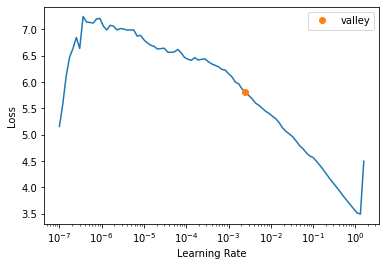

<Figure size 720x720 with 0 Axes>

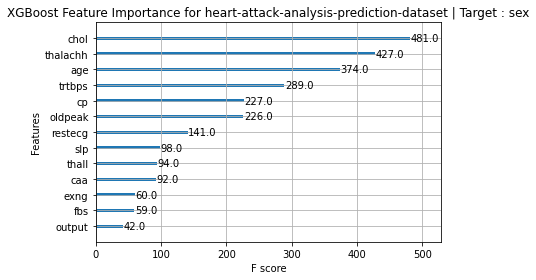

<Figure size 432x288 with 0 Axes>

In [18]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

   feature  importance
0      sex      204.00
1       cp      269.00
2      fbs       71.00
3  restecg      138.00
4     exng       70.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

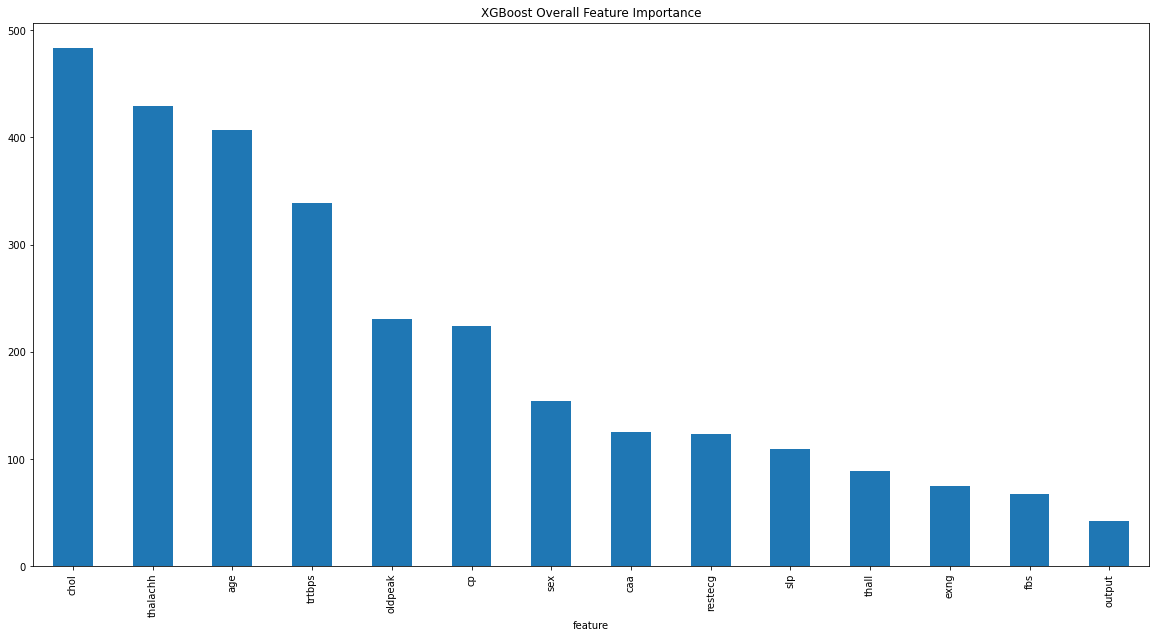

In [19]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [20]:
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

# **To Be Continued...**